# Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, sys
from pathlib import Path
for p in [Path.cwd()] + list(Path.cwd().parents):
    if p.name == 'Multifirefly-Project':
        os.chdir(p)
        sys.path.insert(0, str(p / 'multiff_analysis/multiff_code/methods'))
        break
    
from data_wrangling import specific_utils, process_monkey_information, general_utils
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from neural_data_analysis.neural_analysis_tools.get_neural_data import neural_data_processing
from neural_data_analysis.neural_analysis_tools.visualize_neural_data import plot_neural_data, plot_modeling_result
from neural_data_analysis.neural_analysis_tools.model_neural_data import transform_vars, neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars
from neural_data_analysis.topic_based_neural_analysis.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from neural_data_analysis.topic_based_neural_analysis.planning_and_neural import planning_and_neural_class, pn_utils, pn_helper_class, pn_aligned_by_seg, pn_aligned_by_event
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class, cca_utils, cca_cv_utils
from neural_data_analysis.neural_analysis_tools.cca_methods.cca_plotting import cca_plotting, cca_plot_lag_vs_no_lag, cca_plot_cv
from machine_learning.ml_methods import regression_utils, regz_regression_utils, ml_methods_class, classification_utils, ml_plotting_utils, ml_methods_utils
from planning_analysis.show_planning import nxt_ff_utils, show_planning_utils
from neural_data_analysis.neural_analysis_tools.gpfa_methods import elephant_utils, fit_gpfa_utils, plot_gpfa_utils, gpfa_helper_class
from neural_data_analysis.neural_analysis_tools.align_trials import time_resolved_regression, time_resolved_gpfa_regression,plot_time_resolved_regression
from neural_data_analysis.neural_analysis_tools.align_trials import align_trial_utils
from decision_making_analysis.compare_GUAT_and_TAFT import find_GUAT_or_TAFT_trials

from neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_psth import core_stops_psth, get_stops_utils, psth_postprocessing, psth_stats, compare_events, dpca_utils, prep_stop_psth_data


import sys
import math
import gc
import subprocess
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
import torch
from numpy import pi
import cProfile
import pstats

# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import neo
import rcca

# To fit gpfa
import numpy as np
from importlib import reload
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process
from elephant.gpfa import GPFA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from elephant.gpfa import gpfa_core, gpfa_util

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

print("done")


%load_ext autoreload
%autoreload 2

Set up logging configuration.


/opt/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# retrieve data

In [2]:
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0321"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0329"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0403"
#raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0413"

In [3]:
# # raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0330"
# # raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0328"
# #raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0312"

# #raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0316"
# raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0327"



#raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0221"
#raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0312"
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0327"

In [4]:
reduce_y_var_lags = False
planning_data_by_point_exists_ok = True
y_data_exists_ok = True

pn = pn_aligned_by_event.PlanningAndNeuralEventAligned(raw_data_folder_path=raw_data_folder_path)
pn.prep_data_to_analyze_planning(planning_data_by_point_exists_ok=planning_data_by_point_exists_ok)
# pn.planning_data_by_point, cols_to_drop = general_utils.drop_columns_with_many_nans(
#     pn.planning_data_by_point)
#pn.get_x_and_y_data_for_modeling(exists_ok=y_data_exists_ok, reduce_y_var_lags=reduce_y_var_lags)

if not hasattr(pn, 'spikes_df'):
    pn.retrieve_or_make_monkey_data()
    pn.spikes_df = neural_data_processing.make_spikes_df(pn.raw_data_folder_path, pn.ff_caught_T_sorted,
                                                            sampling_rate=pn.sampling_rate)

Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0327/binned_spikes_df_0p05.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0327/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-25cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0327/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-25cm_0cm
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Bruno/data_0327/behav_data_by_point.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
There are 4 duplicated point_index in bin_info. Note: one_point_index_per_bin is False


In [5]:
pn.spikes_df['cluster'].max()

np.uint32(29)

# NEXT: try stop end time instead

# Get captures

In [6]:
reload(get_stops_utils)

<module 'neural_data_analysis.topic_based_neural_analysis.stop_event_analysis.stop_psth.get_stops_utils' from '/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/topic_based_neural_analysis/stop_event_analysis/stop_psth/get_stops_utils.py'>

In [7]:
pn.make_or_retrieve_stop_category_df()

Retrieved stop_category_df


In [8]:
# Example wiring (mirrors your original usage)
captures_df, valid_captures_df, filtered_no_capture_stops_df, stops_with_stats = get_stops_utils.prepare_no_capture_and_captures(
    monkey_information=pn.monkey_information,
    closest_stop_to_capture_df=pn.closest_stop_to_capture_df,
    ff_caught_T_new=pn.ff_caught_T_new,
    distance_col="distance_from_ff_to_stop",
)   


# Get misses

##  one

In [9]:
columns_to_add = ["stop_id", "stop_id_duration", "stop_id_start_time", "stop_id_end_time"]

pn.make_one_stop_w_ff_df()
one_stop_miss_df = pn.one_stop_w_ff_df[['first_stop_point_index', 'first_stop_time', 'latest_visible_ff']].copy()
one_stop_miss_df.rename(columns={'first_stop_point_index': 'stop_point_index', 'first_stop_time': 'stop_time'}, inplace=True)
one_stop_miss_df[columns_to_add] = pn.monkey_information.loc[one_stop_miss_df['stop_point_index'], columns_to_add].values

Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0327/ff_dataframe.h5


## more

In [10]:
pn.make_or_retrieve_stop_category_df()

In [11]:
pn.get_try_a_few_times_info()
pn.get_give_up_after_trying_info()


In [12]:
pn.TAFT_trials_df

,stop_cluster_id,trial,num_stops,stop_indices,first_stop_point_index,second_stop_point_index,last_stop_point_index,first_stop_time,second_stop_time,last_stop_time,stop_cluster_size,stop_id_duration
0,20,5,2,"[6076, 6113]",6076,6113,6113,100.82587,101.43985,101.43985,2,0.33384
1,21,6,2,"[6188, 6229]",6188,6229,6229,102.65341,103.33399,103.33399,2,0.28234
2,24,8,2,"[6588, 6622]",6588,6622,6622,109.22686,109.79131,109.79131,2,0.43152
3,29,9,3,"[7018, 7055, 7092]",7018,7055,7092,116.34763,116.96171,117.57567,3,0.28310
4,31,11,2,"[7253, 7288]",7253,7288,7288,120.18269,120.76366,120.76366,2,0.29889
...,...,...,...,...,...,...,...,...,...,...,...,...
375,1487,1056,3,"[216975, 217017, 217054]",216975,217017,217054,3571.25798,3571.95520,3572.56940,3,0.44811
376,1488,1057,2,"[217122, 217190]",217122,217190,217190,3573.66498,3574.79346,3574.79346,2,0.68037
377,1493,1061,2,"[217834, 217874]",217834,217874,217874,3585.35112,3586.01516,3586.01516,2,0.63081
378,1495,1063,2,"[218442, 218482]",218442,218482,218482,3595.37736,3596.04138,3596.04138,2,0.49795


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine both dataframes and label them
df_compare = pd.concat([
    giveup_GUAT_last.assign(group='Give-up Last Stop'),
    GUAT_nonfinal.assign(group='Non-final Stop')
])

# Add a common x category so both appear in the same violin
df_compare['category'] = 'Stop Duration'

# Create split violin plot
plt.figure(figsize=(6, 6))
sns.violinplot(
    data=df_compare,
    x='category',
    y='stop_id_duration',
    hue='group',
    split=True,
    inner='quartile',
    width=0.8
)

# Customize
plt.xlabel('')
plt.ylabel('Stop Duration (s)')
plt.title('Stop Duration Distribution: Give-up Last vs Non-final Stops')
plt.legend(title='')
plt.tight_layout()
plt.show()


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all datasets, tagging each
df_compare = pd.concat([
    giveup_GUAT_last.assign(group='GUAT Last'),
    capture_TAFT_last.assign(group='TAFT Last'),
    valid_captures_df.assign(group='Capture'),
    
    GUAT_middle.assign(group='GUAT Middle'),
    TAFT_middle.assign(group='TAFT Middle'),
    
    
    GUAT_nonfinal.assign(group='GUAT Non-final'),
    TAFT_nonfinal.assign(group='TAFT Non-final'),
    
    
    GUAT_first.assign(group='GUAT First'),
    TAFT_first.assign(group='TAFT First'),
    
    
    
    # add more as needed
])

# Plot all as separate violins
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_compare,
    x='group',
    y='stop_id_duration',
    inner='quartile',
    cut=0,
    scale='width'
)

# Customize
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('Stop Duration (s)')
plt.title('Stop Duration Distribution Across Trial Types')
plt.tight_layout()
plt.show()


/var/folders/81/249hbjx960s5t_1dxgdxz6r00000gn/T/ipykernel_7247/1165391188.py:29: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


/var/folders/81/249hbjx960s5t_1dxgdxz6r00000gn/T/ipykernel_7247/832150017.py:20: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


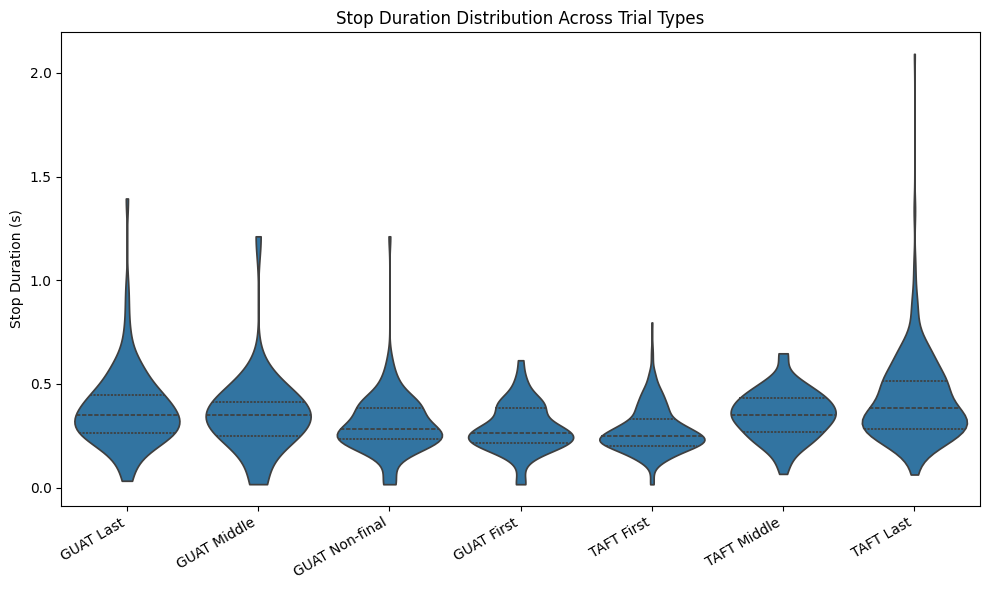

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all datasets, tagging each
df_compare = pd.concat([
    giveup_GUAT_last.assign(group='GUAT Last'),
    GUAT_middle.assign(group='GUAT Middle'),
    GUAT_nonfinal.assign(group='GUAT Non-final'),
    GUAT_first.assign(group='GUAT First'),
    TAFT_first.assign(group='TAFT First'),
    
    TAFT_middle.assign(group='TAFT Middle'),
    capture_TAFT_last.assign(group='TAFT Last'),
    # add more as needed
])

# Plot all as separate violins
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_compare,
    x='group',
    y='stop_id_duration',
    inner='quartile',
    cut=0,
    scale='width'
)

# Customize
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('Stop Duration (s)')
plt.title('Stop Duration Distribution Across Trial Types')
plt.tight_layout()
plt.show()


In [42]:
valid_captures_df

,cur_ff_index,stop_id,time,point_index,stop_time,distance_from_ff_to_stop,stop_point_index,stop_id_duration,stop_id_start_time,stop_id_end_time
0,0,6,73.10374,4399,73.08731,24.87241,4399,0.25124,73.08731,73.33842
1,1,18,92.06280,5543,91.92997,8.47362,5543,0.19658,91.92997,92.13941
2,3,24,97.70595,5886,97.68928,23.15871,5886,0.21579,97.68928,97.90512
3,5,28,101.43985,6113,101.42322,8.34226,6113,0.33382,101.42322,101.75706
4,6,30,103.33399,6229,103.31740,6.57375,6229,0.21580,103.31740,103.53319
...,...,...,...,...,...,...,...,...,...,...
987,1060,2103,3580.63686,217548,3580.53722,10.79887,217548,0.94617,3580.53722,3581.48341
988,1061,2105,3586.01516,217874,3585.99855,6.81856,217874,0.63079,3585.99855,3586.62936
989,1062,2106,3590.84557,218167,3590.82895,13.95998,218167,3.07106,3590.82895,3593.90000
990,1063,2108,3596.04138,218482,3596.02478,1.60397,218482,0.49790,3596.02478,3596.52273


In [ ]:
TAFT_last vs capture?

In [65]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_compare, x='group', y='stop_id_duration',
    inner=None, cut=0, scale='width'
)
sns.stripplot(
    data=df_compare, x='group', y='stop_id_duration',
    color='k', alpha=0.25, size=3
)
sns.pointplot(
    data=df_compare, x='group', y='stop_id_duration',
    estimator='median', color='red', markers='D', scale=0.7
)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


/var/folders/81/249hbjx960s5t_1dxgdxz6r00000gn/T/ipykernel_7247/3662015502.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/81/249hbjx960s5t_1dxgdxz6r00000gn/T/ipykernel_7247/3662015502.py:10: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(


In [45]:
df_compare

,stop_cluster_id,trial,num_stops,stop_point_index,first_stop_point_index,second_stop_point_index,last_stop_point_index,first_stop_time,second_stop_time,last_stop_time,stop_cluster_size,stop_id_duration,stop_time,stop_id,stop_id_start_time,stop_id_end_time,cluster_size,order_in_cluster,is_first,is_last,is_middle,group,cur_ff_index,time,point_index,distance_from_ff_to_stop
0,15.00000,3.00000,2.00000,5747,5702,5747,5747,94.65234,95.39910,95.39910,2.00000,0.28231,95.39910,22,95.38238,95.66469,2.00000,1.00000,False,True,False,GUAT Last,NaN,NaN,NaN,NaN
1,42.00000,18.00000,3.00000,8572,8496,8529,8572,140.60032,141.14810,141.86192,3.00000,0.31541,141.86192,61,141.84532,142.16071,3.00000,2.00000,False,True,False,GUAT Last,NaN,NaN,NaN,NaN
2,57.00000,27.00000,2.00000,10248,10196,10248,10248,168.53760,169.40078,169.40078,2.00000,0.33196,169.40078,83,169.38417,169.71614,2.00000,1.00000,False,True,False,GUAT Last,NaN,NaN,NaN,NaN
3,77.00000,43.00000,2.00000,12524,12485,12524,12524,206.08610,206.73346,206.73346,2.00000,0.31541,206.73346,111,206.71681,207.03225,2.00000,1.00000,False,True,False,GUAT Last,NaN,NaN,NaN,NaN
4,124.00000,78.00000,2.00000,17250,17211,17250,17250,283.54020,284.18744,284.18744,2.00000,0.28220,284.18744,170,284.17089,284.45304,2.00000,1.00000,False,True,False,GUAT Last,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1487.00000,1056.00000,3.00000,216975,216975,217017,217054,3571.25798,3571.95520,3572.56940,3.00000,0.18288,3571.25798,2095,3571.24140,3571.42425,3.00000,0.00000,True,False,False,TAFT First,NaN,NaN,NaN,NaN
376,1488.00000,1057.00000,2.00000,217122,217122,217190,217190,3573.66498,3574.79346,3574.79346,2.00000,0.68039,3573.66498,2098,3573.64840,3574.32877,2.00000,0.00000,True,False,False,TAFT First,NaN,NaN,NaN,NaN
377,1493.00000,1061.00000,2.00000,217834,217834,217874,217874,3585.35112,3586.01516,3586.01516,2.00000,0.26562,3585.35112,2104,3585.33451,3585.60018,2.00000,0.00000,True,False,False,TAFT First,NaN,NaN,NaN,NaN
378,1495.00000,1063.00000,2.00000,218442,218442,218482,218482,3595.37736,3596.04138,3596.04138,2.00000,0.26562,3595.37736,2107,3595.36077,3595.62637,2.00000,0.00000,True,False,False,TAFT First,NaN,NaN,NaN,NaN


In [48]:
df_compare

,stop_cluster_id,trial,num_stops,stop_point_index,first_stop_point_index,second_stop_point_index,last_stop_point_index,first_stop_time,second_stop_time,last_stop_time,stop_cluster_size,stop_id_duration,stop_time,stop_id,stop_id_start_time,stop_id_end_time,cluster_size,order_in_cluster,is_first,is_last,is_middle,group,cur_ff_index,time,point_index,distance_from_ff_to_stop
0,15.00000,3.00000,2.00000,5747,5702,5747,5747,94.65234,95.39910,95.39910,2.00000,0.28231,95.39910,22,95.38238,95.66469,2.00000,1.00000,False,True,False,GUAT Last,NaN,NaN,NaN,NaN
1,42.00000,18.00000,3.00000,8572,8496,8529,8572,140.60032,141.14810,141.86192,3.00000,0.31541,141.86192,61,141.84532,142.16071,3.00000,2.00000,False,True,False,GUAT Last,NaN,NaN,NaN,NaN
2,57.00000,27.00000,2.00000,10248,10196,10248,10248,168.53760,169.40078,169.40078,2.00000,0.33196,169.40078,83,169.38417,169.71614,2.00000,1.00000,False,True,False,GUAT Last,NaN,NaN,NaN,NaN
3,77.00000,43.00000,2.00000,12524,12485,12524,12524,206.08610,206.73346,206.73346,2.00000,0.31541,206.73346,111,206.71681,207.03225,2.00000,1.00000,False,True,False,GUAT Last,NaN,NaN,NaN,NaN
4,124.00000,78.00000,2.00000,17250,17211,17250,17250,283.54020,284.18744,284.18744,2.00000,0.28220,284.18744,170,284.17089,284.45304,2.00000,1.00000,False,True,False,GUAT Last,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1487.00000,1056.00000,3.00000,216975,216975,217017,217054,3571.25798,3571.95520,3572.56940,3.00000,0.18288,3571.25798,2095,3571.24140,3571.42425,3.00000,0.00000,True,False,False,TAFT First,NaN,NaN,NaN,NaN
376,1488.00000,1057.00000,2.00000,217122,217122,217190,217190,3573.66498,3574.79346,3574.79346,2.00000,0.68039,3573.66498,2098,3573.64840,3574.32877,2.00000,0.00000,True,False,False,TAFT First,NaN,NaN,NaN,NaN
377,1493.00000,1061.00000,2.00000,217834,217834,217874,217874,3585.35112,3586.01516,3586.01516,2.00000,0.26562,3585.35112,2104,3585.33451,3585.60018,2.00000,0.00000,True,False,False,TAFT First,NaN,NaN,NaN,NaN
378,1495.00000,1063.00000,2.00000,218442,218442,218482,218482,3595.37736,3596.04138,3596.04138,2.00000,0.26562,3595.37736,2107,3595.36077,3595.62637,2.00000,0.00000,True,False,False,TAFT First,NaN,NaN,NaN,NaN


In [58]:
df_compare['stop_id_duration'] = df_compare['stop_id_duration'].astype(float)

In [56]:
df_compare['stop_id_duration'].dtype


dtype('O')

In [59]:
from itertools import combinations
from scipy.stats import mannwhitneyu

groups = df_compare['group'].unique()
pairs = list(combinations(groups, 2))

for g1, g2 in pairs:
    x1 = df_compare.loc[df_compare['group'] == g1, 'stop_id_duration']
    x2 = df_compare.loc[df_compare['group'] == g2, 'stop_id_duration']
    stat, p = mannwhitneyu(x1, x2, alternative='two-sided')
    print(f'{g1} vs {g2}: p = {p:.4f}')


GUAT Last vs TAFT Last: p = 0.0268
GUAT Last vs Capture: p = 0.6872
GUAT Last vs GUAT Middle: p = 0.4602
GUAT Last vs TAFT Middle: p = 0.6650
GUAT Last vs GUAT Non-final: p = 0.0001
GUAT Last vs TAFT Non-final: p = 0.0000
GUAT Last vs GUAT First: p = 0.0000
GUAT Last vs TAFT First: p = 0.0000
TAFT Last vs Capture: p = 0.0012
TAFT Last vs GUAT Middle: p = 0.0292
TAFT Last vs TAFT Middle: p = 0.0044
TAFT Last vs GUAT Non-final: p = 0.0000
TAFT Last vs TAFT Non-final: p = 0.0000
TAFT Last vs GUAT First: p = 0.0000
TAFT Last vs TAFT First: p = 0.0000
Capture vs GUAT Middle: p = 0.2901
Capture vs TAFT Middle: p = 0.2988
Capture vs GUAT Non-final: p = 0.0000
Capture vs TAFT Non-final: p = 0.0000
Capture vs GUAT First: p = 0.0000
Capture vs TAFT First: p = 0.0000
GUAT Middle vs TAFT Middle: p = 0.6188
GUAT Middle vs GUAT Non-final: p = 0.0503
GUAT Middle vs TAFT Non-final: p = 0.0091
GUAT Middle vs GUAT First: p = 0.0119
GUAT Middle vs TAFT First: p = 0.0008
TAFT Middle vs GUAT Non-final: p =

In [61]:
from scipy.stats import kruskal

# omnibus across groups
samples = [df_compare.loc[df_compare['group'] == g, 'stop_id_duration'] for g in df_compare['group'].unique()]
kw_stat, kw_p = kruskal(*samples)
print(f'Overall Kruskal–Wallis: H={kw_stat:.3f}, p={kw_p:.2e}')


Overall Kruskal–Wallis: H=321.327, p=1.18e-64


In [51]:
df_compare['stop_id_duration'].isna().value_counts()


stop_id_duration
False    2689
Name: count, dtype: int64

In [62]:
df_compare.groupby('group')['stop_id_duration'].median().sort_values()


group
TAFT First       0.24902
GUAT First       0.26562
TAFT Non-final   0.26562
GUAT Non-final   0.28213
GUAT Last        0.34857
Capture          0.34860
TAFT Middle      0.34861
GUAT Middle      0.34862
TAFT Last        0.38183
Name: stop_id_duration, dtype: float64

In [24]:
pn.GUAT_trials_df

,stop_cluster_id,trial,num_stops,stop_indices,first_stop_point_index,second_stop_point_index,last_stop_point_index,first_stop_time,second_stop_time,last_stop_time,stop_cluster_size,stop_id_duration
0,15,3,2,"[5702, 5747]",5702,5747,5747,94.65234,95.39910,95.39910,2,0.28231
1,42,18,3,"[8496, 8529, 8572]",8496,8529,8572,140.60032,141.14810,141.86192,3,0.33207
2,57,27,2,"[10196, 10248]",10196,10248,10248,168.53760,169.40078,169.40078,2,0.41497
3,77,43,2,"[12485, 12524]",12485,12524,12524,206.08610,206.73346,206.73346,2,0.31544
4,124,78,2,"[17211, 17250]",17211,17250,17250,283.54020,284.18744,284.18744,2,0.28214
...,...,...,...,...,...,...,...,...,...,...,...,...
96,1425,1007,2,"[206837, 206863]",206837,206863,206863,3404.39797,3404.82955,3404.82955,2,0.14939
97,1452,1030,3,"[210812, 210859, 210907]",210812,210859,210907,3469.75091,3470.53112,3471.32789,3,0.69715
98,1465,1039,3,"[213126, 213169, 213220]",213126,213169,213220,3507.86322,3508.57700,3509.42334,3,0.56426
99,1468,1041,4,"[213539, 213585, 213685, 213716]",213539,213585,213716,3514.67073,3515.41670,3517.59125,4,1.21171


In [ ]:
now i want to also add GUAT_first, TAFT_first, GUAT_middle, TAFT_middle,capture_TAFT_last, etc, into comparison

In [32]:
columns_to_add = ["stop_id", "stop_id_duration", "stop_id_start_time", "stop_id_end_time"]
shared_columns = ["stop_point_index", "stop_time"] + columns_to_add

# --- Build expanded + ordered tables for GUAT / TAFT ---
GUAT_expanded = get_stops_utils._expand_trials(pn.GUAT_trials_df, pn.monkey_information)
TAFT_expanded = get_stops_utils._expand_trials(pn.TAFT_trials_df, pn.monkey_information)

# add stop_id to GUAT_trials_df and TAFT_trials_df
GUAT_expanded[columns_to_add] = pn.monkey_information.loc[GUAT_expanded['stop_point_index'], columns_to_add].values
TAFT_expanded[columns_to_add] = pn.monkey_information.loc[TAFT_expanded['stop_point_index'], columns_to_add].values


GUAT = get_stops_utils._add_cluster_ordering(GUAT_expanded)
TAFT = get_stops_utils._add_cluster_ordering(TAFT_expanded)

# --- Per-cluster slices (consistent, vectorized) ---
# First stop in each cluster
GUAT_first = GUAT[GUAT["is_first"]].reset_index(drop=True)
TAFT_first = TAFT[TAFT["is_first"]].reset_index(drop=True)

# Last stop in each cluster
giveup_GUAT_last = GUAT[GUAT["is_last"]].reset_index(drop=True)
capture_TAFT_last = TAFT[TAFT["is_last"]].reset_index(drop=True)

# Middle stops (exclude first and last)
GUAT_middle = GUAT[GUAT["is_middle"]].reset_index(drop=True)
TAFT_middle = TAFT[TAFT["is_middle"]].reset_index(drop=True)

# “First several” = all but the last stop in each cluster
GUAT_nonfinal = GUAT[GUAT["order_in_cluster"] < GUAT["cluster_size"] - 1].reset_index(drop=True)
TAFT_nonfinal = TAFT[TAFT["order_in_cluster"] < TAFT["cluster_size"] - 1].reset_index(drop=True)

# Combine the “first several” from both, keep only columns you care about, then sort by index
both_nonfinal = (
    pd.concat(
        [
            GUAT_nonfinal[shared_columns],
            TAFT_nonfinal[shared_columns],
        ],
        ignore_index=True
    )
    .sort_values("stop_point_index")
    .reset_index(drop=True)
)

persist_both_first = pd.concat([GUAT_first[shared_columns], 
                         TAFT_first[shared_columns]])

both_middle = pd.concat([GUAT_middle[shared_columns], 
                         TAFT_middle[shared_columns]])

# Optional: if you also want “last several” (all but the first), it’s symmetrical:
# giveup_GUAT_last_several = GUAT[GUAT["order_in_cluster"] > 0].reset_index(drop=True)
# capture_TAFT_last_several = TAFT[TAFT["order_in_cluster"] > 0].reset_index(drop=True)

giveup_GUAT_last_plus_single_miss = pd.concat([giveup_GUAT_last[shared_columns], 
                                         one_stop_miss_df[shared_columns]])

all_misses = pd.concat([one_stop_miss_df[shared_columns], 
                                         GUAT_expanded[shared_columns],
                                         TAFT_nonfinal[shared_columns]
                                         ])

all_first_misses = pd.concat(
    [one_stop_miss_df[shared_columns], GUAT_first[shared_columns], TAFT_first[shared_columns]],
    ignore_index=True
)

all_last_misses = pd.concat(
    [one_stop_miss_df[shared_columns], giveup_GUAT_last[shared_columns]],
    ignore_index=True
)

# captures not in TAFT last (assuming capture_TAFT_last is a subset of captures)
captures_minus_TAFT_last = compare_events.diff_by(valid_captures_df, capture_TAFT_last, key='stop_id')

# non-captures excluding those flagged as 'all_misses'
non_captures_minus_all_misses = compare_events.diff_by(filtered_no_capture_stops_df, all_misses, key='stop_id')


# ===COMPARE EVENTS===

In [ ]:

# ---------- dataset registry (canonical) ----------
datasets_raw = {
    'captures': valid_captures_df.copy(),
    'no_capture': filtered_no_capture_stops_df.copy(),
    'persist_nonfinal': both_nonfinal.copy(),
    'persist_middle': both_middle.copy(),
    'GUAT_first': GUAT_first.copy(),
    'GUAT_middle': GUAT_middle.copy(),
    'TAFT_middle': TAFT_middle.copy(),
    'giveup_GUAT_last': giveup_GUAT_last.copy(),
    'capture_TAFT_last': capture_TAFT_last.copy(),
    'giveup_single_miss': one_stop_miss_df.copy(),
    'persist_both_first': persist_both_first.copy(),
    'GUAT_nonfinal': GUAT_nonfinal.copy(),
    'TAFT_nonfinal': TAFT_nonfinal.copy(),
    'giveup_GUAT_last_plus_single_miss': giveup_GUAT_last_plus_single_miss.copy(),
    'captures_minus_TAFT_last': captures_minus_TAFT_last.copy(),
    'all_misses': all_misses.copy(),
    'non_captures_minus_all_misses': non_captures_minus_all_misses.copy(),
    'all_first_misses': all_first_misses.copy(),
    'all_last_misses': all_last_misses.copy(),
}

# normalize schema + dedupe within each dataset
datasets = {k: compare_events.dedupe_within(compare_events.ensure_event_schema(v)) for k, v in datasets_raw.items()}

comparisons = compare_events.build_comparisons([
    {'a': 'captures', 'b': 'no_capture', 'key': 'captures_vs_no_capture', 'title': 'Capture vs No Capture'},
    {'a': 'captures', 'b': 'all_misses', 'key': 'captures_vs_all_misses', 'title': 'Capture vs Miss'},

    {'a': 'captures_minus_TAFT_last', 'b': 'capture_TAFT_last',
     'key': 'first_vs_eventual_capture',
     'title': 'First-Shot Capture vs Eventual Capture'},

    {'a': 'giveup_single_miss', 'b': 'giveup_GUAT_last',
     'key': 'first_giveup_vs_retry_then_giveup',
     'title': 'First-Attempt Give-up vs Retry then Give-up'},
    {'a': 'giveup_single_miss', 'b': 'persist_both_first',
     'key': 'first_giveup_vs_first_persist',
     'title': 'First-Attempt Give-up vs First-Attempt Persist'},
    {'a': 'giveup_single_miss', 'b': 'GUAT_first',
     'key': 'first_giveup_vs_first_GUAT',
     'title': 'First-Attempt Give-up vs First-Attempt GUAT'},
    
    
    {'a': 'GUAT_nonfinal', 'b': 'TAFT_nonfinal',
     'key': 'guat_persist_vs_taft_persist',
     'title': 'GUAT Early Persists vs TAFT Early Persists'},
    {'a': 'GUAT_middle', 'b': 'TAFT_middle',
     'key': 'guat_mid_vs_taft_mid',
     'title': 'GUAT Middle Persists vs TAFT Middle Persists'},

    {'a': 'all_misses', 'b': 'non_captures_minus_all_misses',
     'key': 'non_attempts_vs_all_misses',
     'title': 'Miss vs Non-Attempt'},
    {'a': 'non_captures_minus_all_misses', 'b': 'giveup_single_miss',
     'key': 'non_attempts_vs_single_miss',
     'title': 'Non-Attempt vs Single-Attempt Miss'},
    {'a': 'non_captures_minus_all_misses', 'b': 'all_first_misses',
     'key': 'non_attempts_vs_first_miss',
     'title': 'Non-Attempt vs First-Attempt Miss'},
    {'a': 'non_captures_minus_all_misses', 'b': 'all_last_misses',
     'key': 'non_attempts_vs_last_misses',
     'title': 'Non-Attempt vs Last-Attempt Miss'},

    
    # # harder to interpret (because of the confounds in stops & captures surrounding the current stop)
    # {'a': 'persist_nonfinal', 'b': 'giveup_GUAT_last_plus_single_miss'},
    # {'a': 'persist_middle',   'b': 'giveup_GUAT_last_plus_single_miss'},
    # {'a': 'persist_nonfinal', 'b': 'giveup_GUAT_last'},
    # {'a': 'persist_middle',  'b': 'giveup_GUAT_last'},    
    # {'a': 'giveup_GUAT_last', 'b': 'capture_TAFT_last'},    
])


compare_events.validate(datasets, comparisons)


# Run

aligning captures and no_capture by stop start
Align by stop Start


aligning captures and all_misses by stop start
Align by stop Start


aligning captures_minus_TAFT_last and capture_TAFT_last by stop start
Align by stop Start


aligning giveup_single_miss and giveup_GUAT_last by stop start
Align by stop Start


aligning giveup_single_miss and persist_both_first by stop start
Align by stop Start


aligning giveup_single_miss and GUAT_first by stop start
Align by stop Start


aligning persist_GUAT_nonfinal and persist_TAFT_nonfinal by stop start
Align by stop Start


aligning GUAT_middle and TAFT_middle by stop start
Align by stop Start


aligning all_misses and non_captures_minus_all_misses by stop start
Align by stop Start


aligning non_captures_minus_all_misses and giveup_single_miss by stop start
Align by stop Start


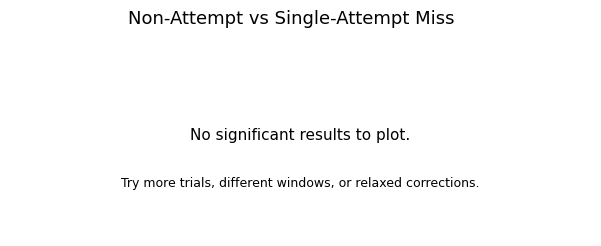

aligning non_captures_minus_all_misses and all_first_misses by stop start
Align by stop Start


aligning non_captures_minus_all_misses and all_last_misses by stop start
Align by stop Start


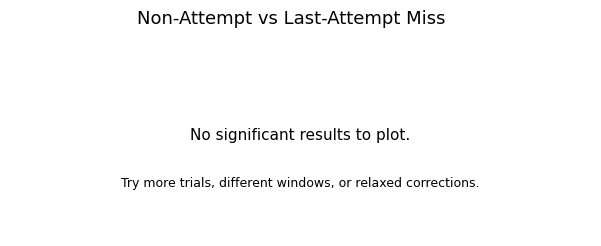

In [16]:
cfg = core_stops_psth.PSTHConfig(
    pre_window=0.5,
    post_window=0.5,
    bin_width=0.05,
    smoothing_sigma=0.1,
    min_trials=5,
    normalize="zscore",            # try: None, "sub", or "div"
)

runs = compare_events.run_all_comparisons(
    comparisons, datasets, pn.spikes_df, pn.monkey_information, cfg,
    align_by_stop_end=False
)


# SELECT

In [ ]:
# capture vs no capture
event_a_df=valid_captures_df
event_b_df=filtered_no_capture_stops_df

event_a_label = 'valid_captures_df'
event_b_label = 'filtered_no_capture_stops_df'


# persist vs give up
event_a_df=both_nonfinal
event_b_df=giveup_GUAT_last

event_a_label = 'both_nonfinal'
event_b_label = 'giveup_GUAT_last'


# persist (shrunken) vs give up
event_a_df=both_middle
event_b_df=giveup_GUAT_last

event_a_label = 'both_middle'
event_b_label = 'giveup_GUAT_last'


# persist vs give up (expanded)
event_a_df=both_nonfinal
event_b_df=giveup_GUAT_last_plus_single_miss

event_a_label = 'both_nonfinal'
event_b_label = 'giveup_GUAT_last_plus_single_miss'


# persist (shrunken) vs give up (expanded)
event_a_df=both_nonfinal
event_b_df=giveup_GUAT_last_plus_single_miss

event_a_label = 'both_nonfinal'
event_b_label = 'giveup_GUAT_last_plus_single_miss'

# give up in single miss and give up in GUAT
event_a_df=one_stop_miss_df
event_b_df=giveup_GUAT_last

event_a_label = 'one_stop_miss_df'
event_b_label = 'giveup_GUAT_last'


# give up in single miss and not give up in persist_both_first
event_a_df=one_stop_miss_df
event_b_df=persist_both_first

event_a_label = 'one_stop_miss_df'
event_b_label = 'persist_both_first'

# GUAT first several vs TAFT first several
event_a_df=GUAT_nonfinal
event_b_df=TAFT_nonfinal

event_a_label = 'GUAT_nonfinal'
event_b_label = 'TAFT_nonfinal'


# GUAT last vs TAFT last
event_a_df=giveup_GUAT_last
event_b_df=capture_TAFT_last

event_a_label = 'giveup_GUAT_last'
event_b_label = 'capture_TAFT_last'

# capture (not in TAFT) vs TAFT last
valid_captures_df_subset = valid_captures_df[~valid_captures_df['stop_id'].isin(capture_TAFT_last['stop_id'])].copy()

event_a_df=valid_captures_df_subset
event_b_df=capture_TAFT_last

event_a_label = 'valid_captures_df_subset'
event_b_label = 'capture_TAFT_last'


# all captures vs all misses
event_a_df=valid_captures_df
event_b_df=all_misses

event_a_label = 'valid_captures_df'
event_b_label = 'all_misses'


# all misses vs non-capture stops
non_captures_minus_all_misses = filtered_no_capture_stops_df[~filtered_no_capture_stops_df['stop_id'].isin(all_misses['stop_id'])].copy()

event_a_df=non_captures_minus_all_misses
event_b_df=all_misses

event_a_label = 'non_captures_minus_all_misses'
event_b_label = 'all_misses'


# all first misses vs non-capture stops
non_captures_minus_all_misses = filtered_no_capture_stops_df[~filtered_no_capture_stops_df['stop_id'].isin(all_misses['stop_id'])].copy()

all_first_misses = pd.concat([one_stop_miss_df[shared_columns], 
                                         GUAT_first[shared_columns],
                                         TAFT_first[shared_columns]
                                         ])


event_a_df=non_captures_minus_all_misses
event_b_df=all_first_misses

event_a_label = 'non_captures_minus_all_misses'
event_b_label = 'all_first_misses'





# run class

valid_captures_df vs filtered_no_capture_stops_df


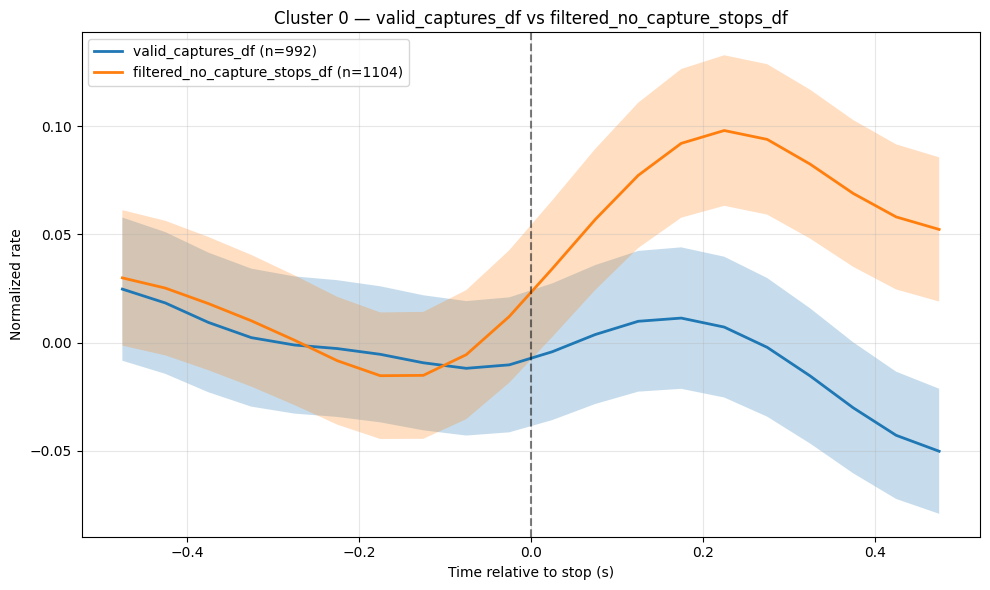

   cluster                 window       p  cohens_d  sig_FDR
21      21     early_dip(0.0–0.3) 0.00000   8.36482     True
20      20     early_dip(0.0–0.3) 0.00000   0.39605     True
26      26     early_dip(0.0–0.3) 0.00000   0.44889     True
28      28     early_dip(0.0–0.3) 0.00000  -0.21251     True
14      14     early_dip(0.0–0.3) 0.00001  -0.19069     True
23      23     early_dip(0.0–0.3) 0.00060  -0.15654     True
22      22     early_dip(0.0–0.3) 0.00353   0.10639     True
13      13     early_dip(0.0–0.3) 0.01246  -0.11798     True
56      26  late_rebound(0.3–0.8) 0.00000   1.06772     True
50      20  late_rebound(0.3–0.8) 0.00000   0.84294     True
41      11  late_rebound(0.3–0.8) 0.00000  -0.35234     True
44      14  late_rebound(0.3–0.8) 0.00000  -0.24072     True
49      19  late_rebound(0.3–0.8) 0.00000   0.16587     True
58      28  late_rebound(0.3–0.8) 0.00004  -0.17083     True
51      21  late_rebound(0.3–0.8) 0.00018   0.16422     True
45      15  late_rebound

In [18]:
# capture vs no capture
event_a_df=valid_captures_df
event_b_df=filtered_no_capture_stops_df

event_a_label = 'valid_captures_df'
event_b_label = 'filtered_no_capture_stops_df'

print(f'{event_a_label} vs {event_b_label}')
print('=====================================================')


event_a_df['stop_time'] = event_a_df['stop_id_start_time']
event_b_df['stop_time'] = event_b_df['stop_id_start_time']


cfg = core_stops_psth.PSTHConfig(
    pre_window=0.5,
    post_window=0.5,
    bin_width=0.05,
    smoothing_sigma=0.1,
    min_trials=5,
    normalize="zscore",            # try: None, "sub", or "div"
)

an = core_stops_psth.create_psth_around_stops(pn.spikes_df, pn.monkey_information,
                                                 event_a_df=event_a_df,
                                                 event_b_df=event_b_df,
                                                 event_a_label=event_a_label,
                                                 event_b_label=event_b_label,
                                                 config=cfg,
                                                 )

fig2 = an.plot_comparison(cluster_idx=0)
plt.show()


windows = {
    "pre_bump(-0.3–0.0)": (-0.3, 0.0),
    "early_dip(0.0–0.3)": (0.0, 0.3),
    "late_rebound(0.3–0.8)": (0.3, 0.8),
}
    
summary = psth_postprocessing.compare_windows(an, windows, alpha=0.05)
summary_sub = summary.loc[summary['sig_FDR'], ['cluster', 'window', 'p', 'cohens_d', 'sig_FDR']].copy()
summary_sub = summary_sub.sort_values(["sig_FDR", "window", "p"], ascending=[False, True, True])
print(summary_sub)


In [19]:


windows = {
    "pre_baseline(-0.5–-0.2)": (-0.5, -0.2),
    "pre_bump(-0.2–-0.1)": (-0.2, -0.1),
    "pre_bump2(-0.1–0.0)": (-0.1, 0.0),
    # "pre_bump3(-0.2--0.0)": (-0.2, -0.0),
    "early_dip(0.0–0.1)": (0.0, 0.1),
    "early_rebound(0.1–0.2)": (0.1, 0.2),
    "early_rebound2(0.2–0.3)": (0.2, 0.3),
    "early_rebound3(0.3–0.4)": (0.3, 0.4),
    "early_rebound4(0.4–0.5)": (0.4, 0.5),
    "late_rebound(0.5–0.8)": (0.5, 0.8),
    "post_tail(0.8–1.2)": (0.8, 1.2),
}

summary = psth_postprocessing.compare_windows(an, windows, alpha=0.05)
summary_sub = summary[summary['sig_FDR']].copy()
df = summary_sub.sort_values(["sig_FDR", "window", "p"], ascending=[False, True, True])
df

,cluster,window,p,U,cohens_d,event_a_mean,event_b_mean,n_event_a,n_event_b,sig_FDR
21,21,early_dip(0.0–0.1),0.00000,947288.00000,2.38505,4.87231,0.00604,992,1104,True
14,14,early_dip(0.0–0.1),0.00000,482577.50000,-0.22642,14.92608,16.91425,992,1104,True
28,28,early_dip(0.0–0.1),0.00014,498480.00000,-0.16120,5.08065,5.99034,992,1104,True
23,23,early_dip(0.0–0.1),0.00262,510635.50000,-0.12005,4.58333,5.51329,992,1104,True
24,24,early_dip(0.0–0.1),0.00309,515003.00000,-0.09885,2.91667,3.53261,992,1104,True
51,21,early_rebound(0.1–0.2),0.00000,870560.00000,1.73920,3.93817,0.00604,992,1104,True
58,28,early_rebound(0.1–0.2),0.00043,502363.00000,-0.14605,4.97984,5.82126,992,1104,True
54,24,early_rebound(0.1–0.2),0.00577,516803.50000,-0.11025,3.23253,4.00362,992,1104,True
41,11,early_rebound(0.1–0.2),0.00605,585071.00000,0.15902,19.55645,17.36111,992,1104,True
86,26,early_rebound2(0.2–0.3),0.00000,768876.00000,0.79040,4.88575,1.50966,992,1104,True


In [20]:
summary.sort_values(["sig_FDR", "p"], ascending=[False, True]).head(20)

,cluster,window,p,U,cohens_d,event_a_mean,event_b_mean,n_event_a,n_event_b,sig_FDR
21,21,early_dip(0.0–0.1),0.00000,947288.00000,2.38505,4.87231,0.00604,992,1104,True
51,21,early_rebound(0.1–0.2),0.00000,870560.00000,1.73920,3.93817,0.00604,992,1104,True
116,26,early_rebound3(0.3–0.4),0.00000,881049.00000,1.25729,5.97446,1.30435,992,1104,True
110,20,early_rebound3(0.3–0.4),0.00000,877573.00000,1.07968,6.72715,1.75121,992,1104,True
86,26,early_rebound2(0.2–0.3),0.00000,768876.00000,0.79040,4.88575,1.50966,992,1104,True
80,20,early_rebound2(0.2–0.3),0.00000,772991.00000,0.65459,5.55108,2.19807,992,1104,True
81,21,early_rebound2(0.2–0.3),0.00000,592848.00000,0.43613,0.55108,0.00000,992,1104,True
131,11,early_rebound4(0.4–0.5),0.00000,441857.50000,-0.33800,12.86290,17.31884,992,1104,True
101,11,early_rebound3(0.3–0.4),0.00000,462894.50000,-0.26696,13.99194,17.45169,992,1104,True
291,21,pre_bump2(-0.1–0.0),0.00000,563592.00000,0.25213,0.19489,0.00000,992,1104,True


# Other analysis

## AUC: just pre or post

In [21]:
import numpy as np
from typing import Iterable, Sequence, Tuple, Optional
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# --- core: build X,y with optional unit selection ---
def build_Xy(an, t0: float, t1: float, units: Optional[Sequence] = None, standardize: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    seg = an.psth_data['segments']; time = an.psth_data['psth']['time_axis']; bw = an.config.bin_width
    i0 = int(np.searchsorted(time, t0, side='left')); i1 = int(np.searchsorted(time, t1, side='right'))
    Xa = seg['event_a'][:, i0:i1, :].mean(axis=1) / bw   # nA x U
    Xb = seg['event_b'][:, i0:i1, :].mean(axis=1) / bw   # nB x U
    X = np.vstack([Xa, Xb])                              # (nA+nB) x U
    y = np.r_[np.ones(len(Xa), int), np.zeros(len(Xb), int)]

    # select units if requested
    unit_ids = an.clusters  # original cluster labels
    if units is not None:
        # 'units' can be indices into columns OR original cluster labels
        if all(isinstance(u, (int, np.integer)) for u in units) and set(units).issubset(set(range(X.shape[1]))):
            cols = np.array(list(units), int)
        else:
            # map labels -> column indices
            col_map = {lab: j for j, lab in enumerate(unit_ids)}
            cols = np.array([col_map[u] for u in units], int)
        X = X[:, cols]
        unit_ids = unit_ids[cols]

    if standardize:
        sc = StandardScaler().fit(X)
        X = sc.transform(X)

    return X, y, unit_ids

def decode_auc_cv(X: np.ndarray, y: np.ndarray, k: int = 5, seed: int = 0, C: float = 1.0, class_weight=None) -> Tuple[float, float]:
    cv = StratifiedKFold(k, shuffle=True, random_state=seed)
    aucs = []
    for tr, te in cv.split(X, y):
        clf = LogisticRegression(max_iter=1000, C=C, class_weight=class_weight, solver='lbfgs')
        clf.fit(X[tr], y[tr])
        p = clf.predict_proba(X[te])[:, 1]
        aucs.append(roc_auc_score(y[te], p))
    aucs = np.asarray(aucs, float)
    return float(np.mean(aucs)), float(np.std(aucs))

# --- 1) per-unit (single-cluster) AUCs ---
def per_unit_auc_df(an, window=(-0.3, 0.0), k=5, seed=0, standardize=False, include_sd=True) -> pd.DataFrame:
    X, y, unit_ids = build_Xy(an, *window, standardize=standardize)
    rows = []
    for j, cid in enumerate(unit_ids):
        m, s = decode_auc_cv(X[:, [j]], y, k=k, seed=seed)
        rows.append({'cluster': int(cid) if str(cid).isdigit() else cid, 'auc': float(m), 'sd_cv': float(s)})
    df = pd.DataFrame(rows).sort_values('auc', ascending=False).reset_index(drop=True)
    df['delta'] = df['auc'] - 0.5
    df['rank'] = np.arange(1, len(df) + 1)
    cols = ['rank', 'cluster', 'auc', 'delta'] + (['sd_cv'] if include_sd else [])
    return df[cols]


# --- 2) subset decoding (choose a list of units) ---
def subset_auc(an, units: Sequence, window=(-0.3, 0.0), k=5, seed=0, standardize=True) -> Tuple[float, float]:
    X, y, _ = build_Xy(an, *window, units=units, standardize=standardize)
    return decode_auc_cv(X, y, k=k, seed=seed)

# --- 3) neuron-drop / top-K curve ---
def neuron_drop_curve(an, window=(-0.3, 0.0), k=5, seed=0, rank_by='univariate', standardize=True, max_k=None):
    """
    rank_by: 'univariate' (per-unit AUC vs labels), or 'coef' (coef magnitude from a full model)
    returns dict with 'order' (cluster IDs in rank order) and 'curve' (list of AUCs for K=1..max_k)
    """
    X, y, unit_ids = build_Xy(an, *window, standardize=standardize)

    # ranking
    if rank_by == 'univariate':
        scores = np.full(X.shape[1], -np.inf)
        for j in range(X.shape[1]):
            try:
                scores[j] = roc_auc_score(y, X[:, j])
                scores[j] = max(scores[j], 1 - scores[j])  # make it >= 0.5
            except Exception:
                scores[j] = 0.5
        order = np.argsort(-scores)  # high to low
    elif rank_by == 'coef':
        clf = LogisticRegression(max_iter=1000, C=1.0, solver='lbfgs').fit(X, y)
        scores = np.abs(clf.coef_.ravel())
        order = np.argsort(-scores)
    else:
        raise ValueError("rank_by must be 'univariate' or 'coef'")

    order_ids = unit_ids[order]
    Kmax = X.shape[1] if max_k is None else min(max_k, X.shape[1])
    curve = []
    for K in range(1, Kmax + 1):
        cols = order[:K]
        auc_mean, _ = decode_auc_cv(X[:, cols], y, k=k, seed=seed)
        curve.append(auc_mean)
    return {'order_ids': order_ids, 'curve': np.array(curve), 'rank_scores': scores[order]}

# --- 4) convenience wrappers you can call directly ---
def auc_all_units(an, window=(-0.3, 0.0), **cvkw):
    X, y, _ = build_Xy(an, *window, standardize=True)
    return decode_auc_cv(X, y, **cvkw)

def auc_single_unit(an, unit, window=(-0.3, 0.0), **cvkw):
    return subset_auc(an, units=[unit], window=window, **cvkw)

def auc_topK_units(an, K, window=(-0.3, 0.0), rank_by='univariate', **cvkw):
    rank = neuron_drop_curve(an, window=window, rank_by=rank_by, **{k:v for k,v in cvkw.items() if k in ('k','seed','standardize')})
    return float(rank['curve'][K-1]), rank


import matplotlib.pyplot as plt

def plot_unit_auc_bar(df, top=None):
    dd = df.copy()
    if top is not None:
        dd = dd.head(top)
    fig, ax = plt.subplots(figsize=(8, max(3, 0.35*len(dd))))
    ax.barh(dd['cluster'].astype(str), dd['auc'])
    ax.axvline(0.5, linestyle='--', linewidth=1)
    ax.set_xlabel('AUC')
    ax.set_ylabel('Cluster')
    ax.set_title('Single-unit AUC')
    ax.invert_yaxis()
    plt.tight_layout()
    return fig, ax


In [22]:
# All clusters

m, s = auc_all_units(an, window=(-0.3, 0.0), k=5, seed=0)
print('pre-stop AUC (all units):', round(m,3))

m, s = auc_all_units(an, window=(0.05, 0.35), k=5, seed=0)
print('post-stop AUC (all units):', round(m,3))

pre-stop AUC (all units): 0.588
post-stop AUC (all units): 0.954


 rank  cluster   auc  delta sd_cv
    1       28 0.550 +0.050 0.017
    2       14 0.538 +0.038 0.035
    3       25 0.536 +0.036 0.016
    4        8 0.530 +0.030 0.031
    5        9 0.528 +0.028 0.020
    6        0 0.527 +0.027 0.019
    7       29 0.526 +0.026 0.036
    8        5 0.525 +0.025 0.036
    9       15 0.524 +0.024 0.008
   10       10 0.517 +0.017 0.013
   11       21 0.516 +0.016 0.003
   12       20 0.514 +0.014 0.021
   13        1 0.513 +0.013 0.020
   14       23 0.513 +0.013 0.017
   15        4 0.512 +0.012 0.017
   16       22 0.508 +0.008 0.012
   17       17 0.507 +0.007 0.009
   18       26 0.505 +0.005 0.014
   19       12 0.505 +0.005 0.011
   20        7 0.503 +0.003 0.012
   21        2 0.502 +0.002 0.004
   22       18 0.499 -0.001 0.011
   23        6 0.499 -0.001 0.016
   24       19 0.493 -0.007 0.021
   25       13 0.493 -0.007 0.007
   26       16 0.482 -0.018 0.021
   27       27 0.479 -0.021 0.028
   28       24 0.478 -0.022 0.020
   29        3

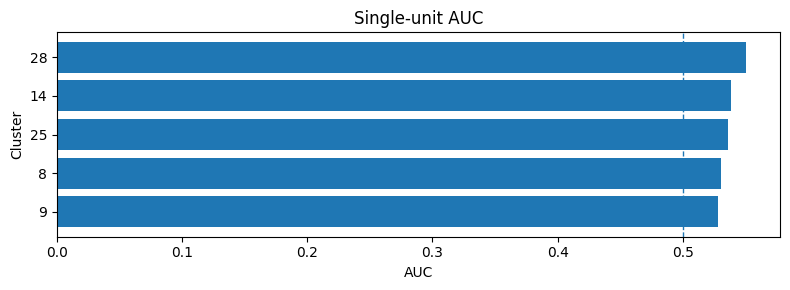

In [23]:
# Per cluster
df = per_unit_auc_df(an, window=(-0.3, 0.0), k=5, seed=0, standardize=True)
print(df.to_string(index=False, formatters={'auc': '{:.3f}'.format,
                                            'delta': '{:+.3f}'.format,
                                            'sd_cv': '{:.3f}'.format}))

# plot all units
fig, ax = plot_unit_auc_bar(df, top=5)
plt.show()


In [ ]:
# top k curve

res = neuron_drop_curve(an, window=(-0.3, 0.0), k=5, seed=0, rank_by='univariate', standardize=True)
print('best K=5 AUC:', float(res['curve'][4]))
# res['order_ids'] gives the unit order; res['curve'] is AUC for K=1..Kmax


best K=5 AUC: 0.5771328016746284


In [ ]:
# pick subset
m, s = subset_auc(an, units=[2, 5], window=(-0.3, 0.0), k=5, seed=0)  # if your labels are 12,27,44
m

0.5268357763037043

## AUC: both pre and post

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# --- reuseable bits ---

def build_Xy(an, t0, t1, standardize=False):
    seg = an.psth_data['segments']; time = an.psth_data['psth']['time_axis']; bw = an.config.bin_width
    i0 = int(np.searchsorted(time, t0, side='left')); i1 = int(np.searchsorted(time, t1, side='right'))
    Xa = seg['event_a'][:, i0:i1, :].mean(axis=1) / bw
    Xb = seg['event_b'][:, i0:i1, :].mean(axis=1) / bw
    X = np.vstack([Xa, Xb])
    y = np.r_[np.ones(len(Xa), int), np.zeros(len(Xb), int)]
    if standardize:
        sc = StandardScaler().fit(X)
        X = sc.transform(X)
    return X, y

def decode_auc_cv(X, y, k=5, seed=0, C=1.0, class_weight=None):
    cv = StratifiedKFold(k, shuffle=True, random_state=seed)
    aucs = []
    for tr, te in cv.split(X, y):
        clf = LogisticRegression(max_iter=1000, C=C, class_weight=class_weight, solver='lbfgs')
        clf.fit(X[tr], y[tr])
        p = clf.predict_proba(X[te])[:, 1]
        aucs.append(roc_auc_score(y[te], p))
    return float(np.mean(aucs)), float(np.std(aucs))

def per_unit_auc_df(an, window=(-0.3, 0.0), k=5, seed=0, standardize=True) -> pd.DataFrame:
    seg = an.psth_data['segments']; time = an.psth_data['psth']['time_axis']; bw = an.config.bin_width
    i0 = int(np.searchsorted(time, window[0], side='left')); i1 = int(np.searchsorted(time, window[1], side='right'))
    Xa = seg['event_a'][:, i0:i1, :].mean(axis=1) / bw
    Xb = seg['event_b'][:, i0:i1, :].mean(axis=1) / bw
    X = np.vstack([Xa, Xb]); y = np.r_[np.ones(len(Xa), int), np.zeros(len(Xb), int)]
    unit_ids = an.clusters

    if standardize:
        sc = StandardScaler().fit(X)
        X = sc.transform(X)

    rows = []
    for j, cid in enumerate(unit_ids):
        m, s = decode_auc_cv(X[:, [j]], y, k=k, seed=seed)
        rows.append({'cluster': int(cid) if str(cid).isdigit() else cid, 'auc': float(m), 'sd_cv': float(s)})
    df = pd.DataFrame(rows).sort_values('auc', ascending=False).reset_index(drop=True)
    df['delta'] = df['auc'] - 0.5
    df['rank'] = np.arange(1, len(df) + 1)
    return df[['rank', 'cluster', 'auc', 'delta', 'sd_cv']]

# --- pre+post in one go ---

def per_unit_auc_pre_post(an,
                          pre=(-0.3, 0.0),
                          post=(0.05, 0.35),
                          k=5, seed=0, standardize=True):
    df_pre  = per_unit_auc_df(an, window=pre,  k=k, seed=seed, standardize=standardize).rename(columns={'auc':'auc_pre','delta':'delta_pre','sd_cv':'sd_pre'})
    df_post = per_unit_auc_df(an, window=post, k=k, seed=seed, standardize=standardize).rename(columns={'auc':'auc_post','delta':'delta_post','sd_cv':'sd_post'})
    wide = pd.merge(df_pre[['cluster','auc_pre','sd_pre']], df_post[['cluster','auc_post','sd_post']],
                    on='cluster', how='inner')
    wide['delta'] = wide['auc_post'] - wide['auc_pre']
    wide = wide.sort_values(['auc_post'], ascending=False).reset_index(drop=True)

    long = pd.concat([
        pd.DataFrame({'cluster': df_pre['cluster'],  'window': 'pre',  'auc': df_pre['auc_pre']  if 'auc_pre' in df_pre else df_pre['auc']}),
        pd.DataFrame({'cluster': df_post['cluster'], 'window': 'post', 'auc': df_post['auc_post'] if 'auc_post' in df_post else df_post['auc']}),
    ], ignore_index=True)
    return {'wide': wide, 'pre': df_pre, 'post': df_post, 'long': long}

# --- plots ---

def plot_unit_auc_bar(df, top=None, title='Single-unit AUC', xlabel='AUC'):
    dd = df.copy()
    if top is not None:
        dd = dd.head(top)
    fig, ax = plt.subplots(figsize=(8, max(3, 0.35*len(dd))))
    ax.barh(dd['cluster'].astype(str), dd['auc'])
    ax.axvline(0.5, linestyle='--', linewidth=1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Cluster')
    ax.set_title(title)
    ax.invert_yaxis()
    plt.tight_layout()
    return fig, ax

def plot_unit_auc_pre_post_bars(res, top=None, title='Single-unit AUC: pre vs post'):
    pre = res['pre'][['cluster','auc_pre']].rename(columns={'auc_pre':'auc'})
    post = res['post'][['cluster','auc_post']].rename(columns={'auc_post':'auc'})
    # common order by max(pre, post)
    order = (pd.merge(pre, post, on='cluster', how='inner')
               .assign(mx=lambda d: d[['auc_x','auc_y']].max(axis=1))
               .sort_values('mx', ascending=False)['cluster'])
    pre = pre.set_index('cluster').loc[order].reset_index()
    post = post.set_index('cluster').loc[order].reset_index()
    if top is not None:
        pre = pre.head(top); post = post.head(top)
    H = max(3, 0.35*len(pre))
    fig, axes = plt.subplots(1, 2, figsize=(14, H), sharey=True)
    for ax, df_, lab in zip(axes, [pre, post], ['pre', 'post']):
        ax.barh(df_['cluster'].astype(str), df_['auc'])
        ax.axvline(0.5, linestyle='--', linewidth=1)
        ax.set_xlabel('AUC')
        ax.set_title(lab)
        ax.invert_yaxis()
    fig.suptitle(title)
    plt.tight_layout(rect=[0,0,1,0.95])
    return fig, axes

def plot_unit_auc_scatter(wide, title='Pre vs Post single-unit AUC'):
    fig, ax = plt.subplots(figsize=(5.5,5.5))
    ax.scatter(wide['auc_pre'], wide['auc_post'], s=20, alpha=0.8)
    ax.plot([0,1],[0,1], linestyle='--', linewidth=1)
    ax.axvline(0.5, linestyle=':', linewidth=1); ax.axhline(0.5, linestyle=':', linewidth=1)
    ax.set_xlabel('AUC (pre)')
    ax.set_ylabel('AUC (post)')
    ax.set_title(title)
    ax.set_xlim(0.3, 1.0); ax.set_ylim(0.3, 1.0)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    return fig, ax

def plot_auc_delta_bar(wide, top=None, title='Δ AUC (post − pre) by unit'):
    dd = wide.copy().sort_values('delta', ascending=False)
    if top is not None:
        dd = dd.head(top)
    H = max(3, 0.35*len(dd))
    fig, ax = plt.subplots(figsize=(8, H))
    ax.barh(dd['cluster'].astype(str), dd['delta'])
    ax.axvline(0.0, linestyle='--', linewidth=1)
    ax.set_xlabel('Δ AUC (post − pre)')
    ax.set_ylabel('Cluster')
    ax.set_title(title)
    ax.invert_yaxis()
    plt.tight_layout()
    return fig, ax


2025-10-06 15:44:35,638 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-06 15:44:35,639 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-06 15:44:35,645 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-06 15:44:35,738 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-06 15:44:35,739 - INFO - Using categorical units to plot a list of strings that are all parsable as 

(<Figure size 800x525 with 1 Axes>,
 <Axes: title={'center': 'Single-unit AUC (post-stop)'}, xlabel='AUC (post)', ylabel='Cluster'>)

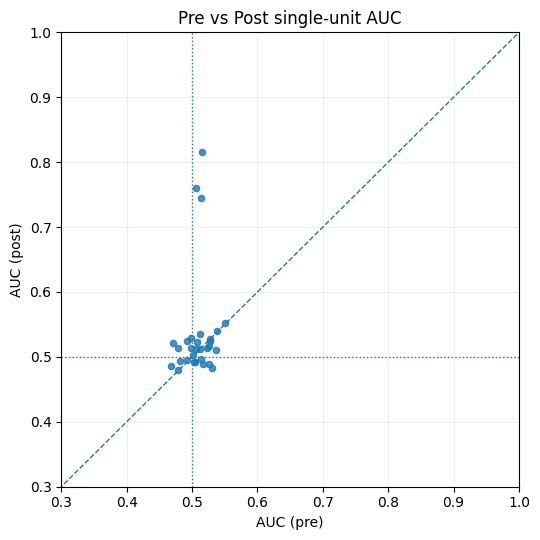

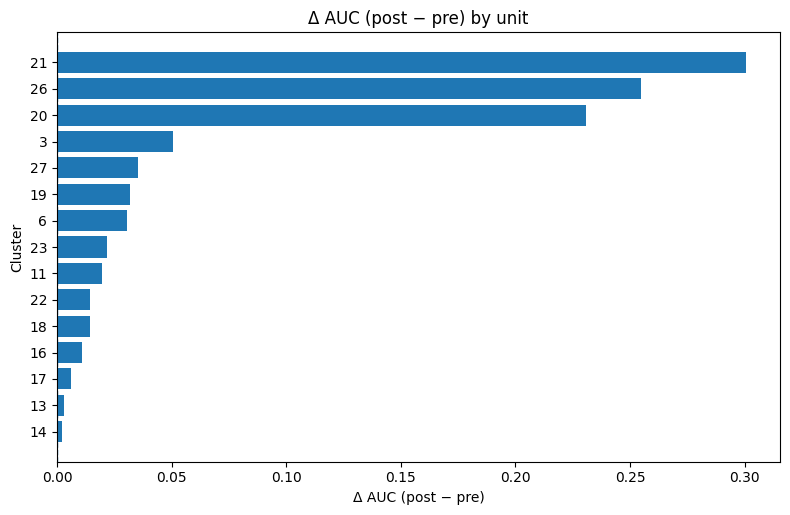

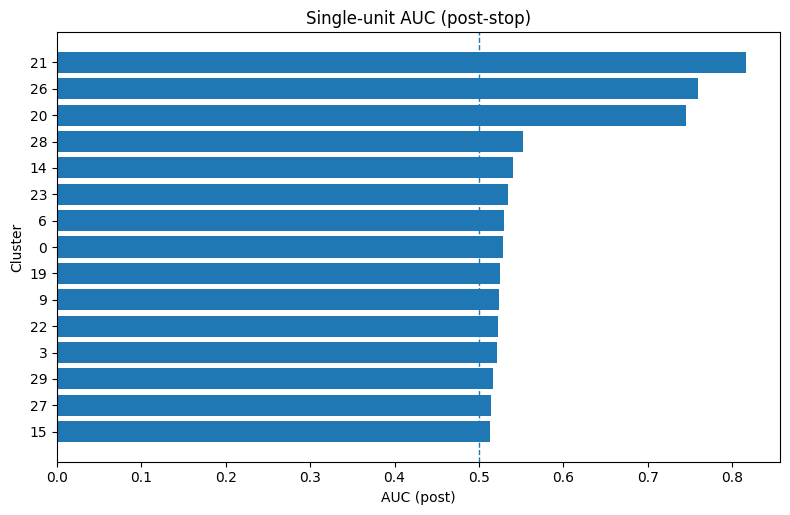

In [ ]:
# compute both
res = per_unit_auc_pre_post(an, pre=(-0.30, 0.00), post=(0.05, 0.35), k=5, seed=0, standardize=True)

# bar charts for each window
plot_unit_auc_pre_post_bars(res, top=15)

# pre vs post scatter
plot_unit_auc_scatter(res['wide'])

# delta bar (who improves after the stop?)
plot_auc_delta_bar(res['wide'], top=15)

# if you only want a post-stop bar:
post_only = res['post'].rename(columns={'auc_post':'auc'})
plot_unit_auc_bar(post_only, top=15, title='Single-unit AUC (post-stop)', xlabel='AUC (post)')


## dPCA (demixed PCA): time vs outcome

Note: it’s across all neurons together.

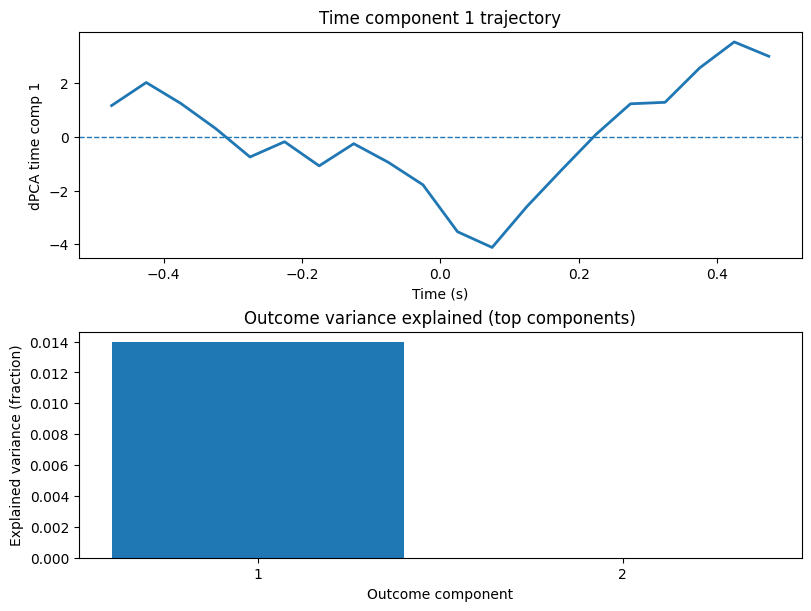

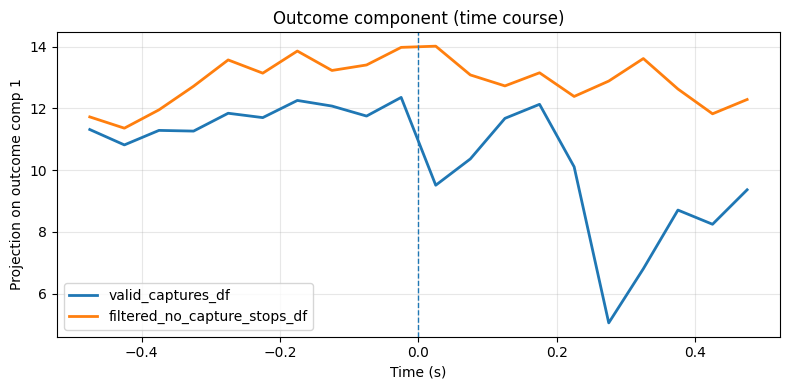

EVR1 obs: 0.013944711536169052 p= 0.000999000999000999
R^2 (reconstruction): -50.618255615234375
AUC all units pre/post: {'pre_mean': 0.5878396415552786, 'pre_sd': 0.013806454020167901, 'post_mean': 0.9537957280345694, 'post_sd': 0.007127643193182224}
 cluster  abs_loading  loading
      14      0.41233  0.41233
      21      0.40449 -0.40449
      26      0.39925 -0.39925
      11      0.30767  0.30767
      20      0.30523 -0.30523
      28      0.27404  0.27404
       5      0.25740 -0.25740
       9      0.16747 -0.16747
      25      0.15799 -0.15799
       8      0.15140  0.15140


In [ ]:
# assuming you have dpca_time_outcome(an) defined:
rep = dpca_utils.run_dpca_report(an, dpca_fn=dpca_utils.dpca_time_outcome, pre_window=(-0.3, 0.0), post_window=(0.05, 0.35),
                      top_k=20, n_perm=1000, seed=0, show=True)

print('EVR1 obs:', rep['evr_perm']['evr1_obs'], 'p=', rep['evr_perm']['p_value'])
print('R^2 (reconstruction):', rep['reconstruction']['R2'])
print('AUC all units pre/post:', rep['auc_all_units'])

# top outcome neurons
print(rep['top_outcome_units'].head(10).to_string(index=False))


In [ ]:
out = rep['out']

# Global vs within-block normalization (helps intuition):
evr_global = out['outcome']['explained_var']           # what you plotted
evr_within = evr_global / np.sum(evr_global) if np.sum(evr_global)>0 else evr_global
print('Outcome EVR (global):', evr_global[:5])
print('Outcome EVR (within-outcome):', evr_within[:5])  # sums to 1 over outcome comps

# Do the blocks add up? (time + outcome ≤ 1 because interaction/residual isn’t modeled):
print('sum(time EVR) + sum(outcome EVR) =',
      np.sum(out['time']['explained_var']) + np.sum(out['outcome']['explained_var']))

# Is it significant?
print('Outcome EVR1:', rep['evr_perm']['evr1_obs'], '  p=', rep['evr_perm']['p_value'])


Outcome EVR (global): [0.01394 0.     ]
Outcome EVR (within-outcome): [1. 0.]
sum(time EVR) + sum(outcome EVR) = 1.0
Outcome EVR1: 0.013944711536169052   p= 0.000999000999000999


## Targeted dim-red (‘outcome axis’)

Idea. Learn a single weight vector w that best predicts event_a vs event_b from pre-stop activity (linear/ridge). Then project full trajectories onto w.

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression

def outcome_axis(an, train_window=(-0.3, 0.0), alpha=1.0,
                 model='ridge', standardize=True, return_trials=True):
    """
    Learn a 1D 'outcome axis' on a training window, then project peri-stop trajectories.

    model: 'ridge' (your original) or 'logreg'
    standardize: z-score units using training-window data
    return_trials: also return per-trial projections (for CIs / AUC)
    """
    if not getattr(an, 'psth_data', None):
        an.run_full_analysis()

    seg  = an.psth_data['segments']
    time = an.psth_data['psth']['time_axis']
    bw   = an.config.bin_width
    i0   = int(np.searchsorted(time, train_window[0], side='left'))
    i1   = int(np.searchsorted(time, train_window[1], side='right'))

    # training features (mean rate in window)
    Xa = seg['event_a'][:, i0:i1, :].mean(axis=1) / bw   # nA x U
    Xb = seg['event_b'][:, i0:i1, :].mean(axis=1) / bw   # nB x U
    X  = np.vstack([Xa, Xb])                             # N x U
    y  = np.r_[np.ones(len(Xa), int), np.zeros(len(Xb), int)]

    scaler = None
    if standardize:
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)

    # fit linear readout
    if model == 'ridge':
        clf = Ridge(alpha=alpha).fit(X, y)
        w = clf.coef_.astype(float)                      # U
        b = float(getattr(clf, 'intercept_', 0.0))
    elif model == 'logreg':
        clf = LogisticRegression(penalty='l2', C=1.0/alpha, solver='lbfgs', max_iter=1000)
        clf.fit(X, y)
        w = clf.coef_.ravel().astype(float)
        b = float(clf.intercept_[0])
    else:
        raise ValueError("model must be 'ridge' or 'logreg'")

    # mean trajectories over time (T x U)
    traj_a = (seg['event_a'] / bw).mean(axis=0)   # T x U
    traj_b = (seg['event_b'] / bw).mean(axis=0)   # T x U
    if standardize:
        # apply the same scaler column-wise to trajectories
        traj = np.vstack([traj_a, traj_b])        # (2T) x U
        traj = scaler.transform(traj)
        traj_a, traj_b = traj[:len(time)], traj[len(time):]

    # project means (time courses)
    proj_a = traj_a @ w + b
    proj_b = traj_b @ w + b

    out = {
        'w': w, 'b': b, 'proj_time': time,
        'proj_a': proj_a, 'proj_b': proj_b,
        'clusters': an.clusters,
        'model': model, 'train_window': train_window,
        'standardize': standardize
    }

    if return_trials:
        # per-trial projections across time (for CIs/AUC without refit)
        A = seg['event_a'] / bw   # nA x T x U
        B = seg['event_b'] / bw   # nB x T x U
        if standardize:
            # flatten trials×time, transform, then reshape back
            AT = A.reshape(-1, A.shape[2])
            BT = B.reshape(-1, B.shape[2])
            AT = scaler.transform(AT); BT = scaler.transform(BT)
            A = AT.reshape(A.shape);  B = BT.reshape(B.shape)
        out['scores_a'] = A @ w + b   # nA x T
        out['scores_b'] = B @ w + b   # nB x T

    return out

def cosine_with_dpca(outcome_axis_w, dpca_out):
    """Cosine similarity between your outcome axis and dPCA outcome comp-1."""
    w1 = outcome_axis_w.ravel()
    w2 = dpca_out['outcome']['components'][0].ravel()
    return float((w1 @ w2) / (np.linalg.norm(w1) * np.linalg.norm(w2) + 1e-12))


In [ ]:
# Learn the axis (train on pre-stop), get time courses

out = outcome_axis(
    an,
    train_window=(-0.3, 0.0),   # train the readout here
    alpha=1.0,                  # ridge strength (or 1/C if model='logreg')
    model='ridge',              # or 'logreg'
    standardize=True,
    return_trials=True
)

# quick plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(out['proj_time'], out['proj_a'], label=getattr(an, 'event_a_label', 'event_a'))
plt.plot(out['proj_time'], out['proj_b'], label=getattr(an, 'event_b_label', 'event_b'))
plt.axvline(0, ls='--', lw=1)
plt.xlabel('Time (s)'); plt.ylabel('Projection score'); plt.legend(); plt.tight_layout()
plt.show()


In [ ]:
# AUC in any window using the fixed axis (no refit)

import numpy as np
from sklearn.metrics import roc_auc_score

def window_auc_from_scores(out, window):
    t = out['proj_time']
    i0 = int(np.searchsorted(t, window[0], side='left'))
    i1 = int(np.searchsorted(t, window[1], side='right'))
    sa = out['scores_a'][:, i0:i1].mean(axis=1)   # per-trial scores in window
    sb = out['scores_b'][:, i0:i1].mean(axis=1)
    y  = np.r_[np.ones(len(sa), int), np.zeros(len(sb), int)]
    s  = np.r_[sa, sb]
    return roc_auc_score(y, s)

auc_pre  = window_auc_from_scores(out, (-0.3, 0.0))
auc_post = window_auc_from_scores(out, (0.05, 0.35))
print('AUC pre:', round(auc_pre,3), '  AUC post:', round(auc_post,3))


AUC pre: 0.63   AUC post: 0.841


In [ ]:
from sklearn.linear_model import Ridge

def outcome_axis(an, train_window=(-0.3, 0.0), alpha=1.0):
    if not getattr(an, 'psth_data', None):
        an.run_full_analysis()
    seg = an.psth_data['segments']
    time = an.psth_data['psth']['time_axis']
    bw = an.config.bin_width

    i0 = int(np.searchsorted(time, train_window[0], side='left'))
    i1 = int(np.searchsorted(time, train_window[1], side='right'))
    Xa = seg['event_a'][:, i0:i1, :].mean(axis=1) / bw    # nA x U
    Xb = seg['event_b'][:, i0:i1, :].mean(axis=1) / bw    # nB x U
    X = np.vstack([Xa, Xb])
    y = np.r_[np.ones(len(Xa), int), np.zeros(len(Xb), int)]

    model = Ridge(alpha=alpha).fit(X, y)
    w = model.coef_.astype(float)                         # U

    # project mean trajectories over time
    traj_a = (seg['event_a'] / bw).mean(axis=0)          # T x U
    traj_b = (seg['event_b'] / bw).mean(axis=0)          # T x U
    proj_a = traj_a @ w                                   # T
    proj_b = traj_b @ w                                   # T
    return {'w': w, 'proj_time': an.psth_data['psth']['time_axis'],
            'proj_a': proj_a, 'proj_b': proj_b, 'clusters': an.clusters}


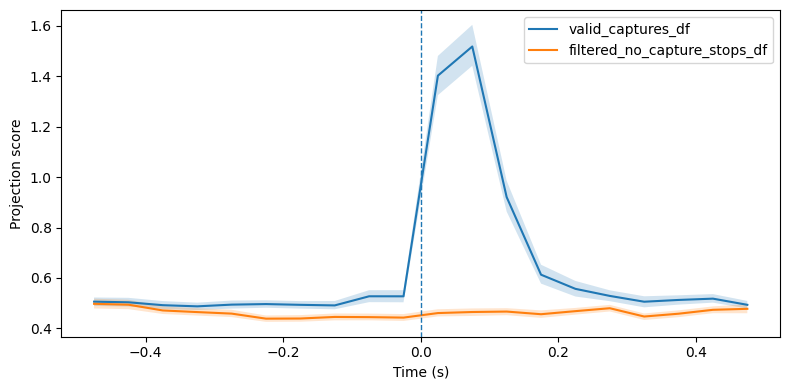

In [ ]:
# Optional: bootstrap CI bands on the time courses

import numpy as np

def mean_ci_band(scores, alpha=0.05, iters=1000, seed=0):
    # scores: trials x time
    rng = np.random.default_rng(seed)
    n, T = scores.shape
    boots = np.empty((iters, T))
    for i in range(iters):
        idx = rng.integers(0, n, n)
        boots[i] = scores[idx].mean(0)
    lo, hi = np.percentile(boots, [100*alpha/2, 100*(1-alpha/2)], axis=0)
    return scores.mean(0), lo, hi

ma, lo_a, hi_a = mean_ci_band(out['scores_a'])
mb, lo_b, hi_b = mean_ci_band(out['scores_b'])

t = out['proj_time']
plt.figure(figsize=(8,4))
plt.plot(t, ma, label=getattr(an, 'event_a_label','event_a'))
plt.fill_between(t, lo_a, hi_a, alpha=0.2, linewidth=0)
plt.plot(t, mb, label=getattr(an, 'event_b_label','event_b'))
plt.fill_between(t, lo_b, hi_b, alpha=0.2, linewidth=0)
plt.axvline(0, ls='--', lw=1); plt.xlabel('Time (s)'); plt.ylabel('Projection score'); plt.legend(); plt.tight_layout()
plt.show()


In [ ]:
# Compare to dPCA outcome axis (alignment)
dp = dpca_utils.dpca_time_outcome(an)
cos = cosine_with_dpca(out['w'], dp)   # uses the helper I gave earlier
print('cosine(outcome_axis, dPCA outcome comp1) =', round(cos,3))


cosine(outcome_axis, dPCA outcome comp1) = -0.692


In [ ]:
# Inspect which neurons drive the axis

import pandas as pd
top = (pd.DataFrame({'cluster': an.clusters, 'w': out['w']})
         .assign(abs_w=lambda d: d['w'].abs())
         .sort_values('abs_w', ascending=False)
         .head(15))
print(top.to_string(index=False))


 cluster        w   abs_w
      14 -0.06354 0.06354
      21  0.05644 0.05644
      29 -0.05348 0.05348
      25  0.04292 0.04292
      28 -0.04094 0.04094
      22  0.02471 0.02471
      15  0.02433 0.02433
       0  0.02245 0.02245
      10  0.01955 0.01955
       5  0.01895 0.01895
      17 -0.01570 0.01570
       6 -0.01516 0.01516
       8 -0.01505 0.01505
       9  0.01349 0.01349
      12  0.01345 0.01345


In [ ]:
# Train on a different window or use logistic

out = outcome_axis(an, train_window=(0.05, 0.35), model='logreg', alpha=1.0)


# quick plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(out['proj_time'], out['proj_a'], label=getattr(an, 'event_a_label', 'event_a'))
plt.plot(out['proj_time'], out['proj_b'], label=getattr(an, 'event_b_label', 'event_b'))
plt.axvline(0, ls='--', lw=1)
plt.xlabel('Time (s)'); plt.ylabel('Projection score'); plt.legend(); plt.tight_layout()
plt.show()


TypeError: outcome_axis() got an unexpected keyword argument 'model'

### ridgeline

In [ ]:
def safe_hedges_g(x, y, eps=1e-3, trim=0.0):
    import numpy as np
    x, y = np.asarray(x, float), np.asarray(y, float)
    if trim > 0:
        qx = np.quantile(x, [trim/2, 1-trim/2]); x = np.clip(x, qx[0], qx[1])
        qy = np.quantile(y, [trim/2, 1-trim/2]); y = np.clip(y, qy[0], qy[1])
    n1, n2 = len(x), len(y)
    if n1 < 2 or n2 < 2: return 0.0
    s1, s2 = np.var(x, ddof=1), np.var(y, ddof=1)
    sp = np.sqrt(((n1-1)*s1 + (n2-1)*s2) / max(n1+n2-2, 1))
    sp = max(sp, eps)
    d = (np.mean(x) - np.mean(y)) / sp
    J = 1 - 3/(4*(n1+n2)-9) if (n1+n2) > 2 else 1.0
    return float(J*d)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def _kde_safe(x, grid, bw=None):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    if x.size < 3:
        return np.zeros_like(grid)
    kde = gaussian_kde(x, bw_method=bw)
    return kde(grid)

def plot_ridge_effect_by_window(summary_df, order='effect', bw=None):
    """
    Ridgeline of Cohen's d distributions across windows (aggregated over clusters).
    summary_df: output from summarize_epochs()/compare_windows()
                needs ['window','cohens_d'] (and optionally 'sig_FDR').
    order: 'effect' (windows ordered by |median d|) or 'as_is' (given order).
    """
    df = summary_df.copy()
    df = df[np.isfinite(df['cohens_d'])]
    if df.empty:
        raise ValueError('no finite effect sizes in summary_df')

    # choose window order
    windows = list(df['window'].unique())
    if order == 'effect':
        med = df.groupby('window', as_index=False)['cohens_d'].median()
        windows = med.reindex(med['cohens_d'].abs().sort_values(ascending=False).index)['window'].tolist()

    # common x-range
    lo = np.nanpercentile(df['cohens_d'], 1)
    hi = np.nanpercentile(df['cohens_d'], 99)
    pad = 0.1 * (hi - lo + 1e-9)
    xgrid = np.linspace(lo - pad, hi + pad, 500)

    fig, ax = plt.subplots(figsize=(8, 0.7 * max(3, len(windows))))
    offset = 0.0
    gap = 1.2

    for w in windows:
        x = df.loc[df['window'] == w, 'cohens_d'].values
        y = _kde_safe(x, xgrid, bw=bw)
        if y.max() > 0:
            y = y / y.max()  # normalize height
        ax.fill_between(xgrid, offset, offset + y, alpha=0.6, linewidth=0)
        ax.plot(xgrid, offset + y, linewidth=1.5)
        ax.text(xgrid[0], offset + 0.05, str(w), va='bottom', fontsize=9)
        offset += gap

    ax.axvline(0, linestyle='--', linewidth=1)
    ax.set_yticks([])
    ax.set_xlabel("Cohen's d (event_a − event_b)")
    ax.set_title('Effect ridgeline across windows (distribution over clusters)')
    plt.tight_layout()
    return fig, ax


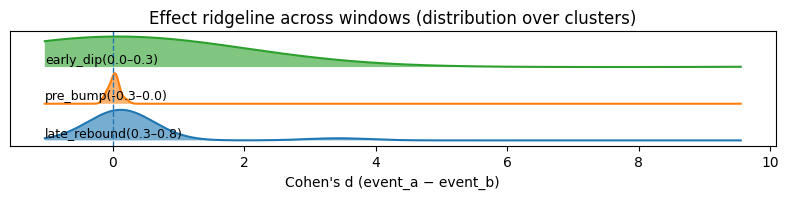

In [ ]:
summary = psth_postprocessing.summarize_epochs(an)   # or compare_windows(...)
plot_ridge_effect_by_window(summary)
plt.show()


## volcano plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_volcano(summary_df, p_col='p', effect_col='cohens_d', by_window=True, sig_col='sig_FDR'):
    """
    Volcano: effect size vs -log10(p).
    summary_df: from summarize_epochs()/compare_windows()/sliding_window_stats
    p_col: 'p' or 'p_value' (whatever your table uses)
    by_window: if True, one panel per window; else single panel with colors by window
    """
    df = summary_df.copy()
    if p_col not in df.columns:
        # try common names
        p_col = 'p_value' if 'p_value' in df.columns else p_col
    df = df[np.isfinite(df[effect_col]) & np.isfinite(df[p_col])]
    if df.empty:
        raise ValueError('no finite rows to plot')

    df['_mlog10p'] = -np.log10(df[p_col].clip(lower=1e-300))

    if by_window:
        windows = list(df['window'].unique())
        n = len(windows)
        fig, axes = plt.subplots(n, 1, figsize=(7, max(3, 2.2*n)), sharex=True)
        if n == 1:
            axes = [axes]
        for ax, w in zip(axes, windows):
            sub = df[df['window'] == w]
            if sig_col in sub.columns:
                sig = sub[sig_col].astype(bool).values
            else:
                sig = np.zeros(len(sub), bool)
            ax.scatter(sub[effect_col][~sig], sub['_mlog10p'][~sig], s=14, alpha=0.6)
            ax.scatter(sub[effect_col][ sig], sub['_mlog10p'][ sig], s=20, alpha=0.9)
            ax.axvline(0, linestyle='--', linewidth=1)
            ax.set_ylabel('-log10(p)')
            ax.set_title(str(w))
        axes[-1].set_xlabel("Effect size (e.g., Cohen's d)")
        plt.tight_layout()
        return fig, axes
    else:
        fig, ax = plt.subplots(figsize=(7,5))
        for w in df['window'].unique():
            sub = df[df['window'] == w]
            ax.scatter(sub[effect_col], sub['_mlog10p'], s=14, alpha=0.7, label=str(w))
        ax.axvline(0, linestyle='--', linewidth=1)
        ax.set_xlabel("Effect size (e.g., Cohen's d)")
        ax.set_ylabel('-log10(p)')
        ax.legend()
        plt.tight_layout()
        return fig, ax


In [ ]:
plot_volcano(summary)
plt.show()

## Noise correlations (pre-stop)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu

def noise_correlations(an, window=(-0.3, 0.0)):
    if not getattr(an, 'psth_data', None):
        an.run_full_analysis()
    seg = an.psth_data['segments']; time = an.psth_data['psth']['time_axis']
    bw = an.config.bin_width
    i0 = int(np.searchsorted(time, window[0], side='left'))
    i1 = int(np.searchsorted(time, window[1], side='right'))

    def corr_offdiag(arr):  # arr: trials x time x units
        if arr.shape[0] < an.config.min_trials:
            return np.array([]), None
        X = arr[:, i0:i1, :].mean(axis=1) / bw            # trials x units
        X = X - X.mean(axis=0, keepdims=True)             # residuals
        C = np.corrcoef(X, rowvar=False)                  # units x units
        iu = np.triu_indices_from(C, k=1)
        return C[iu], C

    rA, CA = corr_offdiag(seg['event_a'])
    rB, CB = corr_offdiag(seg['event_b'])

    stat, p = (np.nan, np.nan)
    if len(rA) > 0 and len(rB) > 0:
        stat, p = mannwhitneyu(rA, rB, alternative='two-sided')

    return {
        'offdiag_event_a': rA, 'offdiag_event_b': rB,
        'matrix_event_a': CA, 'matrix_event_b': CB,
        'mw_stat': stat, 'mw_p': p
    }


# ---------- utilities ----------
def _iqr(x):
    x = np.asarray(x, float)
    q1, q3 = np.nanpercentile(x, [25, 75])
    return float(q3 - q1)

def _sym_lims(*arrays, q=99.0, min_lim=0.2):
    a = np.concatenate([np.ravel(np.abs(z[np.isfinite(z)])) for z in arrays if z is not None and np.size(z)])
    if a.size == 0:
        return (-1, 1)
    m = np.nanpercentile(a, q)
    m = max(m, min_lim)
    return (-m, m)

# ---------- 1) distributions + MWU ----------
def plot_noise_corr_distributions(res, title='Noise correlations (off-diagonal)', bins=40):
    rA, rB = res['offdiag_event_a'], res['offdiag_event_b']
    if rA.size == 0 or rB.size == 0:
        print('Not enough trials for at least one condition.')
        return None, None

    lims = _sym_lims(rA, rB, q=99.0, min_lim=0.2)
    edges = np.linspace(lims[0], lims[1], bins+1)

    mA, mB = np.nanmedian(rA), np.nanmedian(rB)
    iA, iB = _iqr(rA), _iqr(rB)
    p  = res.get('mw_p', np.nan)

    fig, ax = plt.subplots(figsize=(7, 3.2))
    ax.hist(rA, bins=edges, alpha=0.45, density=True, label='event_a', edgecolor='none')
    ax.hist(rB, bins=edges, alpha=0.45, density=True, label='event_b', edgecolor='none')
    ax.axvline(0, ls='--', c='k', lw=1)
    ax.set_xlim(lims); ax.set_xlabel('Noise correlation r'); ax.set_ylabel('Density')
    ax.set_title(title)
    ax.legend(title=f'mWU p={p:.3g}\nmedian/IQR  a={mA:.3f}/{iA:.3f},  b={mB:.3f}/{iB:.3f}')
    plt.tight_layout()
    return fig, ax

# ---------- 2) matrices (upper triangles) ----------
def plot_noise_corr_matrices(res, clusters=None, vmax_q=99.0, title='Noise correlation matrices'):
    CA, CB = res['matrix_event_a'], res['matrix_event_b']
    if CA is None or CB is None:
        print('Correlation matrices not available.')
        return None, None, None

    M = CA.shape[0]
    mask = np.tril_indices(M, k=0)
    A = CA.copy(); B = CB.copy()
    A[mask] = np.nan; B[mask] = np.nan

    vmin, vmax = _sym_lims(A, B, q=vmax_q)
    cmap = plt.get_cmap('coolwarm').copy(); cmap.set_bad('white')

    fig, axes = plt.subplots(1, 3, figsize=(12, 3.4), constrained_layout=True)
    im0 = axes[0].imshow(A, vmin=vmin, vmax=vmax, cmap=cmap)
    axes[0].set_title('event_a')
    im1 = axes[1].imshow(B, vmin=vmin, vmax=vmax, cmap=cmap)
    axes[1].set_title('event_b')
    D = CB - CA
    D[mask] = np.nan
    dvmin, dvmax = _sym_lims(D, q=vmax_q)
    im2 = axes[2].imshow(D, vmin=dvmin, vmax=dvmax, cmap=cmap)
    axes[2].set_title('event_b − event_a')

    for ax in axes:
        ax.set_xticks([]); ax.set_yticks([])
    cbar0 = fig.colorbar(im0, ax=axes[:2], fraction=0.046, pad=0.04)
    cbar0.set_label('r')
    cbar1 = fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    cbar1.set_label('Δr')

    fig.suptitle(title)
    return fig, axes, (vmin, vmax, dvmin, dvmax)

# ---------- 3) paired scatter (per unit-pair) ----------
def plot_noise_corr_scatter(res, title='Pairwise noise corr: event_a vs event_b'):
    rA, rB = res['offdiag_event_a'], res['offdiag_event_b']
    if rA.size == 0 or rB.size == 0 or rA.size != rB.size:
        print('Off-diagonal vectors missing or mismatched sizes.')
        return None, None

    fig, ax = plt.subplots(figsize=(4.2, 4.2))
    ax.scatter(rA, rB, s=10, alpha=0.5)
    lims = _sym_lims(rA, rB, q=99.0)
    ax.plot(lims, lims, ls='--', c='k', lw=1)
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_xlabel('r (event_a)'); ax.set_ylabel('r (event_b)')
    ax.set_title(title)
    # simple summaries
    delta = np.nanmean(rB - rA)
    ax.text(0.05, 0.95, f'Δ mean = {delta:.3f}', transform=ax.transAxes, va='top')
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    return fig, ax

# ---------- 4) one-call convenience ----------
def noise_corr_report(an, window=(-0.3, 0.0), show=True):
    res = noise_correlations(an, window=window)
    title = f'Noise correlations  window=({window[0]:.2f},{window[1]:.2f})'
    fig1, _ = plot_noise_corr_distributions(res, title=title)
    fig2, _, _ = plot_noise_corr_matrices(res, title=title)
    fig3, _ = plot_noise_corr_scatter(res, title=title)
    if show:
        import matplotlib.pyplot as plt
        plt.show()
    return {'res': res, 'fig_dist': fig1, 'fig_mats': fig2, 'fig_scatter': fig3}


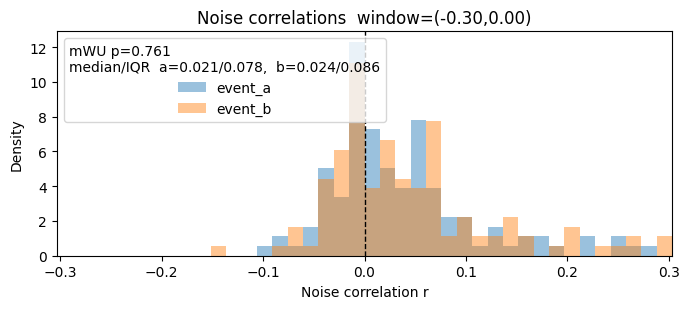

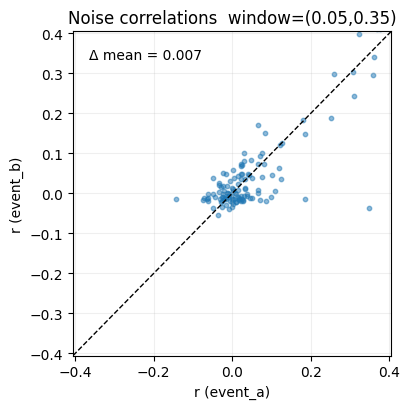

(<Figure size 420x420 with 1 Axes>,
 <Axes: title={'center': 'Pairwise noise corr: event_a vs event_b'}, xlabel='r (event_a)', ylabel='r (event_b)'>)

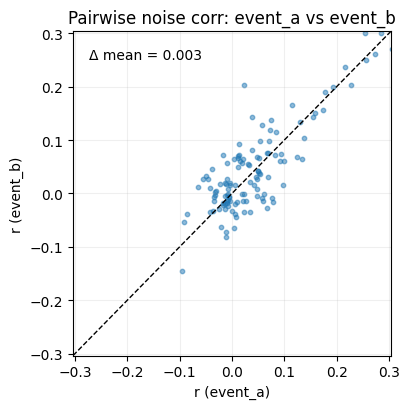

In [ ]:
# # compute + visualize (pre-stop)
out_pre = noise_corr_report(an, window=(-0.30, 0.00))

# post-stop too
out_post = noise_corr_report(an, window=(0.05, 0.35))

# If you only want a specific view:

# res = noise_correlations(an, window=(0.05, 0.35))
res = noise_correlations(an, window=(-0.30, 0.00))
plot_noise_corr_distributions(res)
plot_noise_corr_matrices(res)
plot_noise_corr_scatter(res)


## Poisson GLM with elastic-net (regularized)

In [ ]:
look it up again
https://chatgpt.com/c/68b22a5f-d034-8331-8a9d-7f36b25a802b

# More plots

## Quickly plot PSTHs for the top significant neurons

In [ ]:
import numpy as np

def plot_top_psths(analyzer, summary: pd.DataFrame, epoch: str, top_k=6):
    # pick significant clusters in the epoch, ranked by |d|
    g = summary[(summary["window"] == epoch) & (summary["sig_FDR"])].copy()
    if g.empty:
        print(f"No significant clusters for {epoch}."); return
    g = g.sort_values("cohens_d", key=lambda s: s.abs(), ascending=False).head(top_k)

    # map string cluster ids back to analyzer cluster indices
    plotted = 0
    for cl_str in g["cluster"]:
        # analyzer.clusters holds original IDs (numeric or str)
        # coerce both sides to string for robust matching
        matches = np.where(np.array(list(map(str, analyzer.clusters))) == str(cl_str))[0]
        if len(matches) == 0: 
            continue
        ci = int(matches[0])
        analyzer.plot_comparison(cluster_idx=ci)  # your existing method
        plotted += 1
    if plotted == 0:
        print("Nothing plotted (no matches).")

# usage
plot_top_psths(an, summary, "early_dip(0.0–0.3)", top_k=7)


No significant clusters for early_dip(0.0–0.3).


## Bar chart

In [ ]:
# keep only rows where sig_FDR is True
sig_rows = summary[summary["sig_FDR"]]

# plot effect sizes by epoch
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
sns.barplot(data=sig_rows, x="window", y="cohens_d", hue="cluster", dodge=True)
plt.axhline(0, color="k", lw=1)
plt.ylabel("Cohen's d (capture − miss)")
# change angle of xticks
plt.xticks(rotation=30)
plt.title("Significant neurons across epochs")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Bar chart of significant effects per epoch (one bar per cluster)

In [ ]:
def plot_sig_bars(summary: pd.DataFrame, epoch: str):
    g = summary[(summary["window"] == epoch) & (summary["sig_FDR"])].copy()
    if g.empty:
        print(f"No significant clusters for {epoch}."); return
    g = g.sort_values("cohens_d", key=lambda s: s.abs(), ascending=False)

    fig, ax = plt.subplots(figsize=(10, max(3, 0.35 * len(g))))
    ax.barh(g["cluster"], g["cohens_d"])
    ax.axvline(0, color="k", lw=1, alpha=0.5)
    ax.set_xlabel("Cohen's d (capture − miss)")
    ax.set_ylabel("Cluster")
    ax.set_title(f"Significant clusters in {epoch}")
    plt.tight_layout(); plt.show()

# usage
plot_sig_bars(summary, "pre_bump(-0.3–0.0)")
plot_sig_bars(summary, "early_dip(0.0–0.3)")
plot_sig_bars(summary, "late_rebound(0.3–0.8)")


No significant clusters for pre_bump(-0.3–0.0).
No significant clusters for early_dip(0.0–0.3).
No significant clusters for late_rebound(0.3–0.8).


# Appendix

## distance_from_ff_to_stop cutoff

(0.0, 100.0)

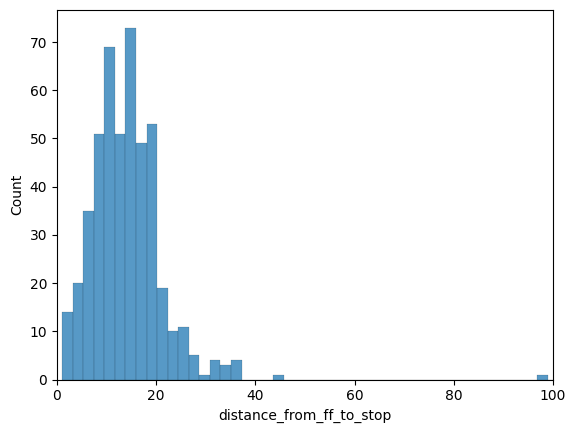

In [ ]:
sns.histplot(captures_df, x='distance_from_ff_to_stop')
plt.xlim(0, 100)

In [ ]:
import numpy as np
import pandas as pd



for method in ['logmad', 'iqr', 'quantile']:
    cutoff, mask = general_utils.outlier_cutoff(captures_df['distance_from_ff_to_stop'], method=method)
    print(f'{method}: {cutoff}')
    
for quantile in [0.995, 0.99, 0.985, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93]:
    cutoff, mask = general_utils.outlier_cutoff(captures_df['distance_from_ff_to_stop'], method='quantile', q=quantile)
    print(f'quantile {quantile}: {cutoff}')    

logmad: 64.52023622916573
iqr: 42.92261195920646
quantile: 720.8326392754215
quantile 0.995: 720.8326392754215
quantile 0.99: 105.1859022500948
quantile 0.985: 35.86812332437094
quantile 0.98: 35.23679228946323
quantile 0.97: 32.58293866656034
quantile 0.96: 27.918422144679482
quantile 0.95: 26.40746534459403
quantile 0.94: 25.80840437324233
quantile 0.93: 24.82061374970869


## Other anchors for stops
https://docs.google.com/document/d/1nJOQlqsyq7eOVtUlL8TAAacC25vXeQvlGfDI-SbQrKE/edit?tab=t.0

In [ ]:
import numpy as np
import pandas as pd

def _finite_diff(y, t):
    dy = np.gradient(y, t)  # robust to uneven dt
    return dy

def anchor_peak_decel(df, pre_window_s=0.5):
    # peak negative acceleration in a window ending at stop onset
    # requires per-stop onset; derive from first time of each stop_id
    onset = df.groupby("stop_id")["time"].min()
    t = df["time"].to_numpy()
    a = _finite_diff(df["speed"].to_numpy(), t)  # acceleration
    df2 = df.assign(accel=a)
    rows = []
    for sid, t0 in onset.items():
        m = (df2["stop_id"]==sid) & (df2["time"].between(t0-pre_window_s, t0, inclusive="left"))
        if not m.any(): 
            continue
        i = df2.loc[m, "accel"].idxmin()
        rows.append((sid, df2.at[i, "time"]))
    out = pd.DataFrame(rows, columns=["stop_id","anchor_time"])
    out["anchor_kind"] = "peak_decel"
    return out





## other processing/windows

In [ ]:

# # Per-cluster plots with bands
# fig1 = an.plot_psth(cluster_idx=None, show_individual=False)


# df = psth_postprocessing.export_psth_to_df(an)              # all clusters
# df_c0 = psth_postprocessing.export_psth_to_df(an, [0])      # just the first cluster


# windows = {
#     "pre_bump(-0.3–0.0)": (-0.3, 0.0),
#     "early_dip(0.0–0.3)": (0.0, 0.3),
#     "late_rebound(0.3–0.8)": (0.3, 0.8),
# }


# windows = {
#     "pre_baseline(-0.6–-0.3)": (-0.6, -0.3),
#     "pre_bump(-0.3–0.0)": (-0.3, 0.0),
#     "early_dip(0.0–0.1)": (0.0, 0.1),
#     "early_rebound(0.1–0.3)": (0.1, 0.3),
#     "late_rebound(0.3–0.8)": (0.3, 0.8),
#     "post_tail(0.8–1.5)": (0.8, 1.5),
# }

## Validate near-miss single stops

In [ ]:
# Check whether "near-miss" stops (one_stop_w_ff_df) are truly not part of a stop cluster.  
# A stop cluster is defined as ≥ 2 stops where each consecutive stop is within 50 cm (cumulative distance).

# --- Step 1: Create one-stop dataframe and assign cluster IDs
pn.make_one_stop_w_ff_df()
pn.monkey_information = find_GUAT_or_TAFT_trials.add_temp_stop_cluster_id(pn.monkey_information)

# --- Step 2: Build stop-cluster summary
stop_cluster_df = (
    pn.monkey_information.loc[pn.monkey_information['whether_new_distinct_stop'], ['point_index', 'stop_cluster_id']]
    .copy()
)
stop_cluster_df['stop_cluster_size'] = (
    stop_cluster_df.groupby('stop_cluster_id')['point_index'].transform('count')
)

# --- Step 3: Merge cluster info into one-stop dataframe (if not already present)
if 'stop_cluster_id' not in pn.one_stop_w_ff_df.columns:
    pn.one_stop_w_ff_df = pn.one_stop_w_ff_df.merge(
        stop_cluster_df.rename(columns={'point_index': 'first_stop_point_index'}),
        on='first_stop_point_index',
        how='left'
    )

# --- Step 4: Inspect any one-stop rows that actually fall in a multi-stop cluster
pn.one_stop_w_ff_df[pn.one_stop_w_ff_df['stop_cluster_size'] > 1]


,point_index,nearby_alive_ff_indices,latest_visible_ff,time,ff_distance,stop_id,stop_cluster_id,stop_cluster_size,num_stops,whether_w_ff_near_stops,stop_time,first_stop_time,first_stop_point_index,stop_indices,target_index


## Check dt between stops in clusters

In [ ]:
import pandas as pd


# Expand so each stop_index gets its own row
GUAT_expanded = pn.GUAT_trials_df.explode("stop_indices").reset_index(drop=True)

# Optionally rename column
GUAT_expanded = GUAT_expanded.rename(columns={"stop_indices": "stop_point_index"})
GUAT_expanded['stop_time'] = pn.monkey_information['time'].loc[GUAT_expanded['stop_point_index']].values

TAFT_expanded = pn.TAFT_trials_df.explode("stop_indices").reset_index(drop=True)

# Optionally rename column
TAFT_expanded = TAFT_expanded.rename(columns={"stop_indices": "stop_point_index"})
TAFT_expanded['stop_time'] = pn.monkey_information['time'].loc[TAFT_expanded['stop_point_index']].values


# group TAFT_expanded by stop_cluster_id and drop the last row of each group
TAFT_expanded.sort_values('stop_point_index', inplace=True)
TAFT_nonfinal = TAFT_expanded.groupby('stop_cluster_id').apply(lambda x: x.iloc[:-1]).reset_index(drop=True)


/var/folders/81/249hbjx960s5t_1dxgdxz6r00000gn/T/ipykernel_60226/2355864191.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  TAFT_first_several = TAFT_expanded.groupby('stop_cluster_id').apply(lambda x: x.iloc[:-1]).reset_index(drop=True)


In [ ]:
GUAT_expanded['dt'] = GUAT_expanded['stop_time'].diff()
TAFT_expanded['dt'] = TAFT_expanded['stop_time'].diff()
GUAT_sub = GUAT_expanded[GUAT_expanded['dt'] < 0.5]
TAFT_sub = TAFT_expanded[TAFT_expanded['dt'] < 0.5]
GUAT_sub


,stop_cluster_id,trial,num_stops,stop_point_index,cluster_index,first_stop_point_index,second_stop_point_index,last_stop_point_index,first_stop_time,second_stop_time,last_stop_time,stop_time,dt
11,92,78,2,12824,6,12796,12824,12824,210.30980,210.77454,210.77454,210.77454,0.46474
22,187,153,2,25741,22,25712,25741,25741,422.57003,423.05138,423.05138,423.05138,0.48135
43,305,255,3,41439,35,41409,41439,41478,680.09747,680.59572,681.24291,680.59572,0.49825
79,448,379,2,59722,54,59695,59722,59722,979.90444,980.35252,980.35252,980.35252,0.44808
81,473,396,3,63329,57,63301,63329,63373,1039.28150,1039.74635,1040.47672,1039.74635,0.46484
84,503,425,2,67810,59,67782,67810,67810,1112.91774,1113.38252,1113.38252,1113.38252,0.46478
86,509,431,3,68765,61,68735,68765,68806,1128.57124,1129.06927,1129.75009,1129.06927,0.49803
92,529,446,2,71135,63,71109,71135,71135,1167.54731,1167.97895,1167.97895,1167.97895,0.43164
94,565,479,3,75400,65,75374,75400,75441,1237.48178,1237.91338,1238.59395,1237.91338,0.43159
106,681,567,2,89756,77,89729,89756,89756,1473.21356,1473.66156,1473.66156,1473.66156,0.44799


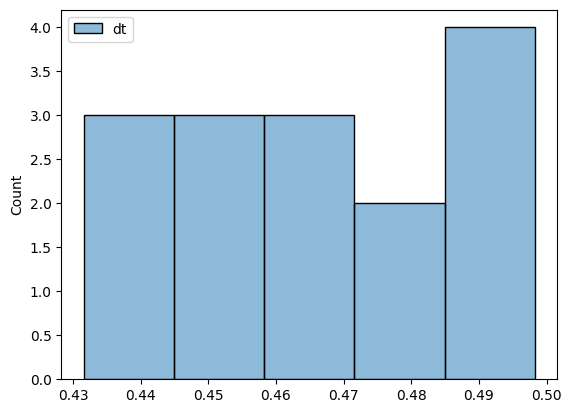

In [ ]:
sns.histplot(GUAT_sub[['dt']])
plt.show()

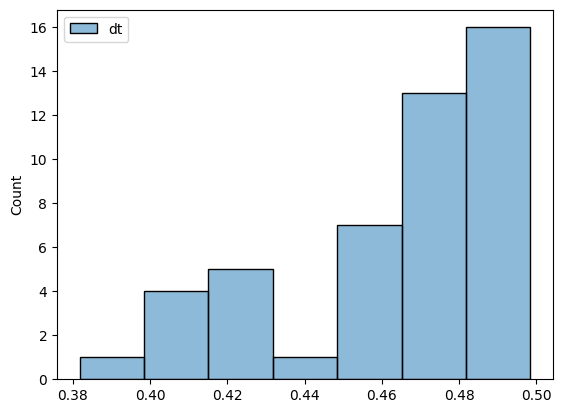

In [ ]:
sns.histplot(TAFT_sub[['dt']])
plt.show()

In [ ]:
GUAT_sub[['dt']].describe()

,dt
count,15.00000
mean,0.46589
std,0.02550
min,0.43159
25%,0.44801
50%,0.46478
75%,0.48969
max,0.49825


In [ ]:
TAFT_sub[['dt']].describe()

,dt
count,47.00000
mean,0.47041
std,0.03000
min,0.38173
25%,0.46476
50%,0.48138
75%,0.49783
max,0.49849


## check inter-stop intervals

In [ ]:
reload(process_monkey_information)

<module 'data_wrangling.process_monkey_information' from '/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/data_wrangling/process_monkey_information.py'>

In [ ]:
pn.monkey_information = process_monkey_information.add_whether_new_distinct_stop_and_stop_id(pn.monkey_information)

In [ ]:
pn.monkey_information

,monkey_x,monkey_y,time,point_index,monkey_angle,monkey_speed,monkey_dw,monkey_x_smr,LDy,RDz,LDz,monkey_dw_smr,monkey_y_smr,RDy,monkey_speed_smr,gaze_mky_view_x,gaze_mky_view_y,gaze_mky_view_angle,gaze_world_x,gaze_world_y,gaze_mky_view_x_l,gaze_mky_view_y_l,gaze_mky_view_angle_l,gaze_world_x_l,gaze_world_y_l,gaze_mky_view_x_r,gaze_mky_view_y_r,gaze_mky_view_angle_r,gaze_world_x_r,gaze_world_y_r,valid_view_point_l,valid_view_point_r,valid_view_point,eye_world_speed,monkey_ddw,monkey_ddv,monkey_speeddummy,crossing_boundary,delta_distance,cum_distance,stop_id,whether_new_distinct_stop,dt,turning_right,trial,stop_cluster_id,stop_cluster_start_point,stop_cluster_end_point,stop_cluster_size,stop_id_duration
0,0.00000,30.80000,0.09134,0,1.57080,0.00000,-184.07138,0.02839,18.80072,-2.28906,-2.33398,-0.00008,30.89159,16.68520,0.07897,75.51017,235.92759,-0.30989,75.51017,266.72759,77.13615,232.23614,-0.32068,77.13615,263.03614,73.88420,239.61905,-0.29909,73.88420,270.41905,True,True,True,490.17629,0.00000,0.00000,0,0,0.00000,0.00000,<NA>,False,0.01686,1,0,<NA>,NaN,NaN,<NA>,NaN
1,0.00000,30.80000,0.10820,1,-1.53228,0.00000,-184.07138,0.02839,18.79927,-2.47827,-2.30957,0.00093,30.89159,16.70114,0.07064,73.21351,227.98977,-0.31039,-64.37982,-199.83997,77.96628,234.69626,-0.32073,-68.87082,-206.72450,68.46073,221.28328,-0.30004,-59.88883,-192.95543,True,True,True,490.17629,92.03569,0.00000,0,0,0.00000,0.00000,<NA>,False,0.01754,1,0,<NA>,NaN,NaN,<NA>,NaN
2,0.00000,30.80000,0.12574,2,-1.53228,0.00000,0.00000,0.02839,18.77463,-2.51001,-2.33398,-0.00123,30.73900,16.73303,0.09274,72.38645,225.35841,-0.31047,-63.65471,-197.17871,77.03028,232.27219,-0.32022,-68.02886,-204.26618,67.74261,218.44464,-0.30071,-59.28055,-190.09124,True,True,True,157.24745,92.03569,0.00000,0,0,0.00000,0.00000,<NA>,False,0.01547,0,0,<NA>,NaN,NaN,<NA>,NaN
3,0.00000,30.80000,0.14121,3,-1.53228,0.00000,0.00000,-0.12420,18.79202,-2.58691,-2.32666,0.00124,30.89159,16.68375,0.01848,71.47833,222.48808,-0.31034,-62.85779,-194.27553,77.34973,232.98021,-0.32055,-68.32081,-204.98598,65.60693,211.99594,-0.30012,-57.39478,-183.56508,True,True,True,194.63186,0.00000,0.00000,0,0,0.00000,0.00000,<NA>,False,0.01654,0,0,<NA>,NaN,NaN,<NA>,NaN
4,0.00000,30.80000,0.15774,4,-1.53228,0.00000,0.00000,0.02839,18.80217,-2.55762,-2.34009,-0.00015,30.73900,16.78232,0.02684,71.81999,222.97226,-0.31121,-63.18055,-194.77251,76.93572,231.62762,-0.32069,-67.95920,-203.61845,66.70425,214.31691,-0.30174,-58.40191,-185.92658,True,True,True,35.83654,0.00000,0.00000,0,0,0.00000,0.00000,<NA>,False,0.01658,0,0,<NA>,NaN,NaN,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219079,-307.92563,255.96219,3598.95314,219079,1.03888,45.15523,-0.00044,-307.74139,3.01184,-9.15918,-11.80420,0.00000,258.40015,0.81369,45.98095,1.73030,54.89810,-0.02925,-278.59087,302.39781,0.56846,47.78080,-0.01190,-283.20198,296.85313,2.89215,62.01539,-0.04660,-273.97975,307.94248,True,True,True,34.78770,-0.00634,-26.37328,1,0,0.74998,698469.79843,<NA>,False,0.01660,1,1337,<NA>,NaN,NaN,<NA>,NaN
219080,-307.79947,256.17801,3598.96975,219080,1.03888,15.05869,0.00000,-307.74139,2.78571,-9.28613,-11.93726,-0.00085,258.55273,0.58321,15.92109,1.49023,54.19924,-0.02520,-279.02607,302.13309,0.34967,47.24255,-0.00740,-283.53737,296.71604,2.63079,61.15592,-0.04299,-274.51476,307.55014,True,True,True,44.51219,0.00022,-18.82279,1,0,0.24999,698470.04842,<NA>,False,0.01665,0,1337,<NA>,NaN,NaN,<NA>,NaN
219081,-307.73642,256.28595,3598.98639,219081,1.03888,7.50966,0.00000,-307.28363,2.87268,-9.44849,-11.96289,0.00008,258.70532,0.44115,6.41793,1.44343,53.61113,-0.02497,-279.30162,301.75791,0.41785,47.13462,-0.00886,-283.47030,296.69637,2.46902,60.08765,-0.04107,-275.13294,306.81945,True,True,True,35.44164,0.00000,-7.52801,1,0,0.12501,698470.17343,<NA>,False,0.01649,0,1337,<NA>,NaN,NaN,<NA>,NaN


In [ ]:

unique_stops_df = (
    pn.monkey_information[['stop_id', 'point_index', 'time', 'stop_id_start_time', 'stop_id_end_time', 'stop_id_duration']].groupby("stop_id", as_index=False, sort=False)
    .first()
    .reset_index(drop=True)
)
unique_stops_df

,stop_id,point_index,time,stop_id_start_time,stop_id_end_time,stop_id_duration
0,0,1364,22.73335,22.73335,24.67574,1.94239
1,1,1542,25.68801,25.68801,25.75444,0.06643
2,2,1577,26.23586,26.23586,26.56787,0.33201
3,3,1629,27.09899,27.09899,27.26502,0.16602
4,4,1696,28.21117,28.21117,28.41069,0.19951
...,...,...,...,...,...,...
2315,2315,218395,3587.64874,3587.64874,3588.26297,0.61424
2316,2316,218565,3590.43754,3590.43754,3590.78609,0.34856
2317,2317,218633,3591.56634,3591.56634,3592.18044,0.61411
2318,2318,218796,3594.25539,3594.25539,3594.73686,0.48148


In [ ]:
unique_stops_df = get_stops_utils.extract_unique_stops(pn.monkey_information)
unique_stops_df

,point_index,time,stop_id_start_time,stop_id_end_time,stop_id_duration
0,1364,22.73335,22.73335,24.67574,1.94239
1,1542,25.68801,25.68801,25.75444,0.06643
2,1577,26.23586,26.23586,26.56787,0.33201
3,1629,27.09899,27.09899,27.26502,0.16602
4,1696,28.21117,28.21117,28.41069,0.19951
...,...,...,...,...,...
2315,218395,3587.64874,3587.64874,3588.26297,0.61424
2316,218565,3590.43754,3590.43754,3590.78609,0.34856
2317,218633,3591.56634,3591.56634,3592.18044,0.61411
2318,218796,3594.25539,3594.25539,3594.73686,0.48148


In [ ]:
unique_stops_df = get_stops_utils.extract_unique_stops(pn.monkey_information)
onsets = unique_stops_df['time'].to_numpy()

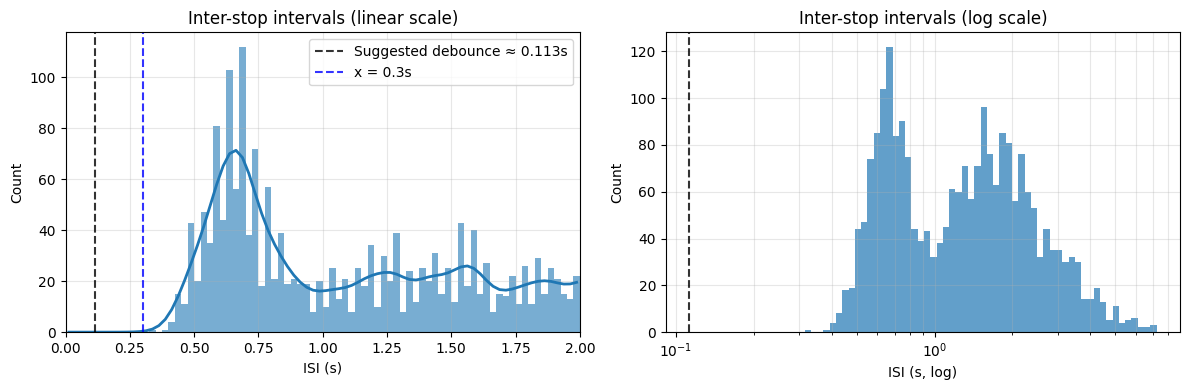

In [ ]:
returned = get_stops_utils.plot_inter_stop_intervals(onsets)
ax1 = returned['ax1']

# add an additional vertical line to the linear plot
additional_vline = 0.3
ax1.axvline(additional_vline, linestyle="--", color="b", alpha=0.8, label=f"x = {additional_vline}s")
ax1.legend()
plt.show()

## check stop durations

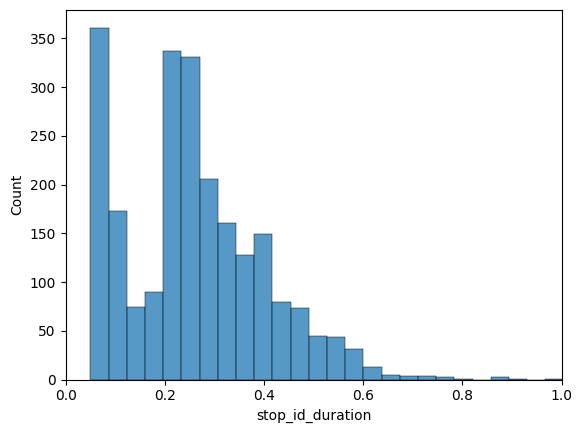

In [ ]:
plt.figure()
ax = sns.histplot(unique_stops_df['stop_id_duration'], bins=100)
ax.set_xlim(0, 1)
plt.show()

## add stop_id

In [ ]:
pn.monkey_information = process_monkey_information.add_whether_new_distinct_stop_and_stop_id(pn.monkey_information)
pn.monkey_information

,monkey_x,monkey_y,time,point_index,monkey_angle,monkey_speed,monkey_dw,monkey_x_smr,LDy,RDz,LDz,monkey_dw_smr,monkey_y_smr,RDy,monkey_speed_smr,gaze_mky_view_x,gaze_mky_view_y,gaze_mky_view_angle,gaze_world_x,gaze_world_y,gaze_mky_view_x_l,gaze_mky_view_y_l,gaze_mky_view_angle_l,gaze_world_x_l,gaze_world_y_l,gaze_mky_view_x_r,gaze_mky_view_y_r,gaze_mky_view_angle_r,gaze_world_x_r,gaze_world_y_r,valid_view_point_l,valid_view_point_r,valid_view_point,eye_world_speed,monkey_ddw,monkey_ddv,monkey_speeddummy,crossing_boundary,delta_distance,cum_distance,stop_id,whether_new_distinct_stop,dt,turning_right,trial,stop_cluster_id,stop_cluster_start_point,stop_cluster_end_point,stop_cluster_size
0,0.00000,30.80000,0.09134,0,1.57080,0.00000,-184.07138,0.02839,18.80072,-2.28906,-2.33398,-0.00008,30.89159,16.68520,0.07897,75.51017,235.92759,-0.30989,75.51017,266.72759,77.13615,232.23614,-0.32068,77.13615,263.03614,73.88420,239.61905,-0.29909,73.88420,270.41905,True,True,True,490.17629,0.00000,0.00000,0,0,0.00000,0.00000,<NA>,False,0.01686,1,0,<NA>,NaN,NaN,<NA>
1,0.00000,30.80000,0.10820,1,-1.53228,0.00000,-184.07138,0.02839,18.79927,-2.47827,-2.30957,0.00093,30.89159,16.70114,0.07064,73.21351,227.98977,-0.31039,-64.37982,-199.83997,77.96628,234.69626,-0.32073,-68.87082,-206.72450,68.46073,221.28328,-0.30004,-59.88883,-192.95543,True,True,True,490.17629,92.03569,0.00000,0,0,0.00000,0.00000,<NA>,False,0.01754,1,0,<NA>,NaN,NaN,<NA>
2,0.00000,30.80000,0.12574,2,-1.53228,0.00000,0.00000,0.02839,18.77463,-2.51001,-2.33398,-0.00123,30.73900,16.73303,0.09274,72.38645,225.35841,-0.31047,-63.65471,-197.17871,77.03028,232.27219,-0.32022,-68.02886,-204.26618,67.74261,218.44464,-0.30071,-59.28055,-190.09124,True,True,True,157.24745,92.03569,0.00000,0,0,0.00000,0.00000,<NA>,False,0.01547,0,0,<NA>,NaN,NaN,<NA>
3,0.00000,30.80000,0.14121,3,-1.53228,0.00000,0.00000,-0.12420,18.79202,-2.58691,-2.32666,0.00124,30.89159,16.68375,0.01848,71.47833,222.48808,-0.31034,-62.85779,-194.27553,77.34973,232.98021,-0.32055,-68.32081,-204.98598,65.60693,211.99594,-0.30012,-57.39478,-183.56508,True,True,True,194.63186,0.00000,0.00000,0,0,0.00000,0.00000,<NA>,False,0.01654,0,0,<NA>,NaN,NaN,<NA>
4,0.00000,30.80000,0.15774,4,-1.53228,0.00000,0.00000,0.02839,18.80217,-2.55762,-2.34009,-0.00015,30.73900,16.78232,0.02684,71.81999,222.97226,-0.31121,-63.18055,-194.77251,76.93572,231.62762,-0.32069,-67.95920,-203.61845,66.70425,214.31691,-0.30174,-58.40191,-185.92658,True,True,True,35.83654,0.00000,0.00000,0,0,0.00000,0.00000,<NA>,False,0.01658,0,0,<NA>,NaN,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219079,-307.92563,255.96219,3598.95314,219079,1.03888,45.15523,-0.00044,-307.74139,3.01184,-9.15918,-11.80420,0.00000,258.40015,0.81369,45.98095,1.73030,54.89810,-0.02925,-278.59087,302.39781,0.56846,47.78080,-0.01190,-283.20198,296.85313,2.89215,62.01539,-0.04660,-273.97975,307.94248,True,True,True,34.78770,-0.00634,-26.37328,1,0,0.74998,698469.79843,<NA>,False,0.01660,1,1337,<NA>,NaN,NaN,<NA>
219080,-307.79947,256.17801,3598.96975,219080,1.03888,15.05869,0.00000,-307.74139,2.78571,-9.28613,-11.93726,-0.00085,258.55273,0.58321,15.92109,1.49023,54.19924,-0.02520,-279.02607,302.13309,0.34967,47.24255,-0.00740,-283.53737,296.71604,2.63079,61.15592,-0.04299,-274.51476,307.55014,True,True,True,44.51219,0.00022,-18.82279,1,0,0.24999,698470.04842,<NA>,False,0.01665,0,1337,<NA>,NaN,NaN,<NA>
219081,-307.73642,256.28595,3598.98639,219081,1.03888,7.50966,0.00000,-307.28363,2.87268,-9.44849,-11.96289,0.00008,258.70532,0.44115,6.41793,1.44343,53.61113,-0.02497,-279.30162,301.75791,0.41785,47.13462,-0.00886,-283.47030,296.69637,2.46902,60.08765,-0.04107,-275.13294,306.81945,True,True,True,35.44164,0.00000,-7.52801,1,0,0.12501,698470.17343,<NA>,False,0.01649,0,1337,<NA>,NaN,NaN,<NA>
219082,-307.73639,256.28592,3599.00288,219082,1.03888

## stop clusters

In [ ]:
for max_cluster_distance in [50, 45, 40, 35, 30, 20, 50]:
    print(f'max_cluster_distance: {max_cluster_distance}')
    pn.monkey_information = find_GUAT_or_TAFT_trials.add_temp_stop_cluster_id(pn.monkey_information, max_cluster_distance=max_cluster_distance, use_ff_caught_time_new_to_separate_clusters=False,
                                                                        col_exists_ok=False)

    stop_sub = pn.monkey_information[pn.monkey_information['stop_id'].notna()].copy()
    stop_sub = stop_sub[['stop_id', 'stop_cluster_id']].drop_duplicates()
    # Compute cluster sizes properly
    stop_sub['cluster_size'] = stop_sub.groupby('stop_cluster_id')['stop_id'].transform('size')

    # Show how many rows belong to clusters of size > 1
    print('number of clusters: ', stop_sub['stop_cluster_id'].unique().shape[0])
    print('number of stops: ', stop_sub['stop_id'].unique().shape[0])
    print('number of clusters with more than 1 stop: ', stop_sub[stop_sub['cluster_size'] > 1].shape[0])
    print('--------------------------------')


max_cluster_distance: 50
number of clusters:  1570
number of stops:  2320
number of clusters with more than 1 stop:  1348
--------------------------------
max_cluster_distance: 45
number of clusters:  1643
number of stops:  2320
number of clusters with more than 1 stop:  1226
--------------------------------
max_cluster_distance: 40
number of clusters:  1796
number of stops:  2320
number of clusters with more than 1 stop:  966
--------------------------------
max_cluster_distance: 35
number of clusters:  2002
number of stops:  2320
number of clusters with more than 1 stop:  593
--------------------------------
max_cluster_distance: 30
number of clusters:  2147
number of stops:  2320
number of clusters with more than 1 stop:  323
--------------------------------
max_cluster_distance: 20
number of clusters:  2285
number of stops:  2320
number of clusters with more than 1 stop:  67
--------------------------------
max_cluster_distance: 50
number of clusters:  1570
number of stops:  2320
n

In [ ]:
num_stops = pn.monkey_information['stop_id'].unique().shape[0]
num_clusters = pn.monkey_information['stop_cluster_id'].unique().shape[0]
num_clusters

2286

## censor_mask_for_event

censor_mdef censor_mask_for_event(t0, all_stops, time_axis, pad=0.15):
    abs_times = t0 + time_axis
    dmin = np.min(np.abs(abs_times[:,None] - all_stops[None,:]), axis=1)
    keep = (dmin >= pad) | np.isclose(abs_times, t0)
    return keep  # bool, shape (len(time_axis),)
ask_for_event